In [1]:
import numpy as np
import psrchive as psr
import matplotlib.pyplot as plt
import os
import astropy.stats as ast
from astropy.utils import NumpyRNGContext
import scipy.stats as scs
%matplotlib notebook

In [2]:
import pandas as pd

In [3]:
cwd = os.getcwd()
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_UWL_01Aug_22/Processed/phase_shifted/timfiles')

In [4]:
df = pd.read_csv('PostRes_32pulint_Chan_all.txt', delim_whitespace=True)

#df.iloc[0:55]

In [5]:
data=df.to_numpy()

In [6]:
data=data.reshape((-1,55,4))

In [7]:
channels=data[0,:,0]
#print(channels)
count = 0
for i in range(data.shape[0]):
    if not (data[i,:,0] == channels).all:
        count += 1
print(count)

0


<IPython.core.display.Javascript object>


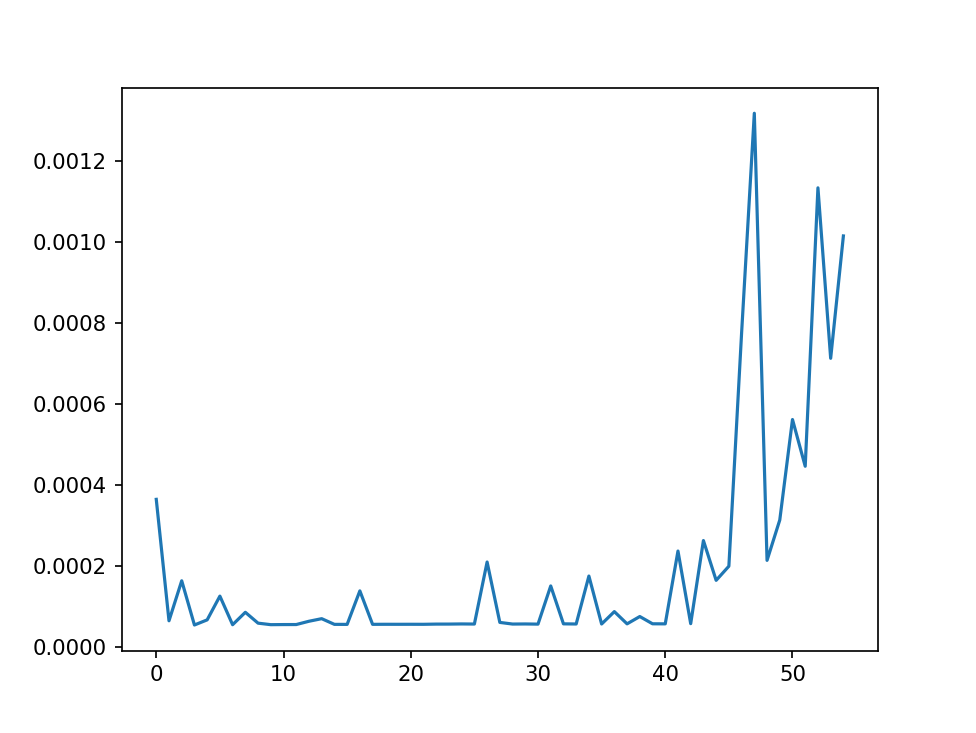

[0, 2, 5, 16, 26, 31, 34, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]


In [8]:
residuals_32p=data[:,:,2]
rms_chns=np.ndarray(residuals_32p.shape[1])
chn_remove=[]
for i in range(residuals_32p.shape[1]):
    rms_chns[i]=np.std(residuals_32p[:,i])
    if (rms_chns[i]> 0.0001):
        chn_remove.append(i)
plt.figure()
plt.plot(rms_chns)
print(chn_remove)
len(chn_remove)

## Remove channels #######
residuals_32p=np.delete(residuals_32p,[0, 2, 5, 16, 26, 31, 34, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54],1)

In [9]:
rem_int=[]
#print([np.absolute(a)>0.0003 for a in residuals_32p[428][:]])
for i in range(residuals_32p.shape[0]):
    if np.any([np.absolute(a)>0.0003 for a in residuals_32p[i][:]]):
        rem_int.append(i)
        
#print(rem_int)

## Remoce Integrations ###
residuals_32p=np.delete(residuals_32p,[36, 89, 107, 147, 150, 175, 183, 233, 320, 395, 428, 724, 776, 840, 844, 857, 859, 938, 960, 961],0)

(946, 35)


<IPython.core.display.Javascript object>


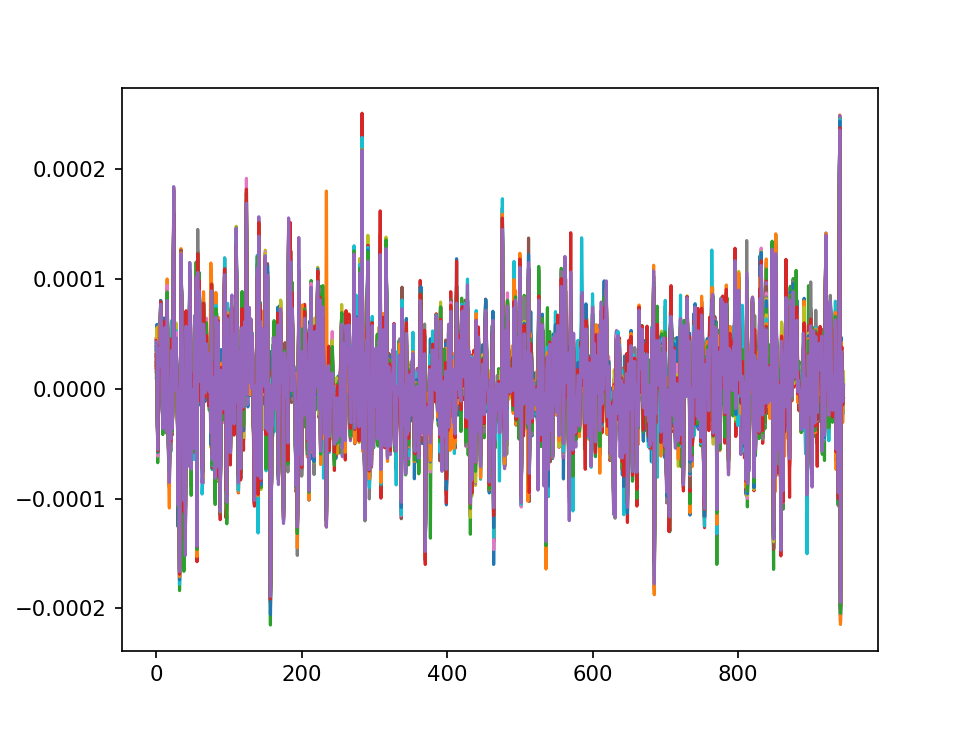

In [10]:
print(residuals_32p.shape)
plt.figure()
plt.plot(residuals_32p)
#plt.plot(residuals_32p[0,:])
#plt.plot(residuals_32p[325,:])

#residuals_32p=data[:,:,2]
#plt.figure()
Fig, Axs = plt.subplots(5,5)

for row, col in [(i,j) for i in range(5) for j in range(5)]:
    Axs[row,col].scatter(residuals_32p[:,row+10],residuals_32p[:,col+10])
    Axs[row,col].set_title('('+str(row+1)+','+str(col+1)+')')
#plt.plot(residuals_32p)


In [11]:
Chn_Freq=data[:,:,1]
Chn_Freq=np.mean(Chn_Freq,axis=0)
Chn_Freq=np.delete(Chn_Freq,[0, 2, 5, 16, 26, 31, 34, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54])
Chn_Freq.shape
print(Chn_Freq)

[ 836.59381571  932.00013251  996.         1112.         1152.
 1236.         1314.         1370.         1406.         1444.
 1506.         1668.         1701.99994792 1876.00009965 1928.
 1968.4        2030.         2075.777778   2134.         2190.46702209
 2234.8        2280.         2517.9999119  2545.55901783 2592.
 2712.         2810.         2850.         2966.         3034.
 3070.         3108.         3176.         3224.         3330.        ]


In [12]:
#### Running bootstrap on residuals_32p to generate samples
with NumpyRNGContext(1):   
    bootresult_32p = ast.bootstrap(residuals_32p, 500)

#residuals_32p = np.loadtxt('res_All_pulses_1000.txt')  # Read post fit residuals_32p from a file into a numpy array.
residuals_32p = np.genfromtxt('PostRes_32pulint_Entire_all.txt')
residuals_32p = residuals_32p.reshape((-1,32))  ## Getting residuals_32p in a matrix [subint,freq]

##Deleting residuals corresponding to bad data
residuals_32p=np.delete(residuals_32p,[538,539],0)
residuals_32p.shape

####### Running bootstrap on residuals_32p to generate samples
with NumpyRNGContext(1):   
    bootresult_32p = ast.bootstrap(residuals_32p, 500)

############### Pearson's Correlation Coefficient #################

######### Create a mar=trix to store correlation coefficient for each sample of residuals
R_32p=np.ndarray([bootresult_32p.shape[0],bootresult_32p.shape[2],bootresult_32p.shape[2]])

######## Calculate pearson Correlation coefficient for all samples
for i in range(bootresult_32p.shape[0]):
    R_32p[i,:,:]=np.corrcoef(bootresult_32p[i,:,:],rowvar=False)

##plotting the mean of correlation coefficient with oth channel as reference 
plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_32p[:,0,:],axis=0),yerr=1.96*(np.std(R_32p[:,0,:],axis=0)),fmt='o')
plt.title("32Pulse Pearson")


<IPython.core.display.Javascript object>


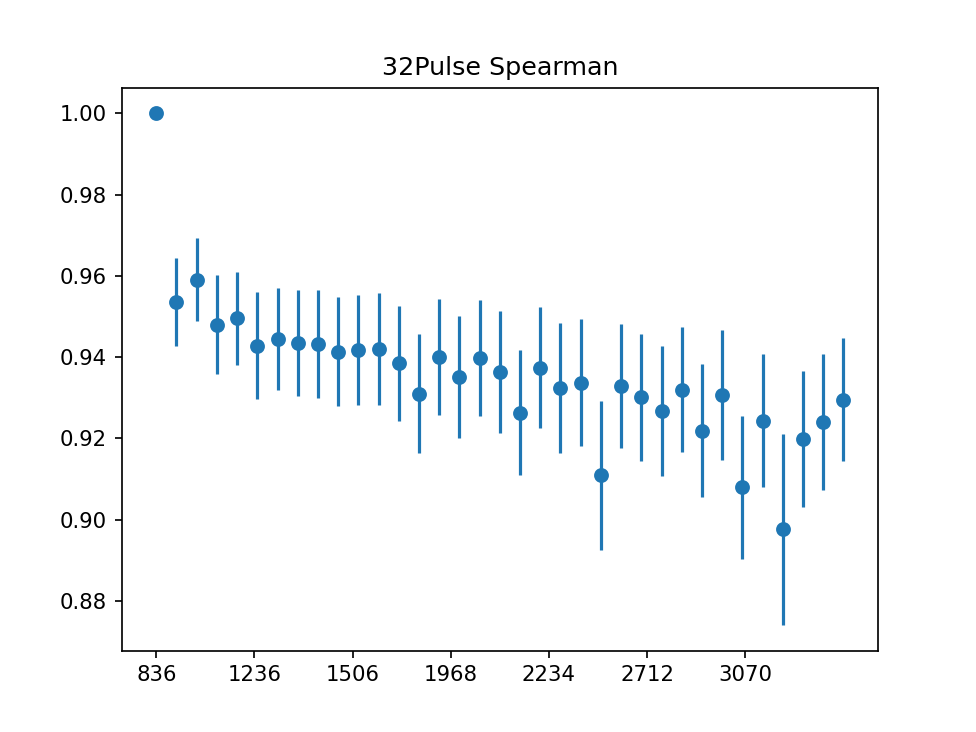

In [13]:
################### Spearman Correlation coefficient ##########

R_32p_spr=np.ndarray([bootresult_32p.shape[0],bootresult_32p.shape[2],bootresult_32p.shape[2]])
R_32p_spr_pval=np.ndarray([bootresult_32p.shape[0],bootresult_32p.shape[2],bootresult_32p.shape[2]])

for i in range(bootresult_32p.shape[0]):
    R_32p_spr[i,:,:]=scs.spearmanr(bootresult_32p[i,:,:],axis=0)[0]
    R_32p_spr_pval[i,:,:]=scs.spearmanr(bootresult_32p[i,:,:],axis=0)[1]

plt.figure()
plt.errorbar(np.linspace(0,residuals_32p.shape[1],num=residuals_32p.shape[1]),np.mean(R_32p_spr[:,0,:],axis=0),yerr=1.96*(np.std(R_32p_spr[:,0,:],axis=0)),fmt='o')
plt.xticks([0,5,10,15,20,25,30],[int(Chn_Freq[5*i]) for i in range(7)])
plt.title("32Pulse Spearman")
plt.show()

#os.chdir(cwd)

In [14]:
df.iloc[0:55]

Chn         Freq  Post_res     Err
0     1   806.000000  0.000129  65.928
1     2   837.200000  0.000035  14.780
2     3   864.000000  0.000024  10.872
3     4   932.000000  0.000019   6.682
4     5   996.000000  0.000032   2.226
5     6  1049.000000  0.000032   3.002
6     7  1112.000000  0.000025   3.832
7     8  1152.000000  0.000021   3.017
8    10  1236.000000  0.000031   5.041
9    11  1314.000000  0.000028   2.496
10   12  1370.000000  0.000031   4.584
11   13  1406.000000  0.000034   2.310
12   14  1444.000000  0.000021   2.678
13   15  1506.000000  0.000035   2.766
14   18  1668.000000  0.000030   2.277
15   19  1702.000000  0.000023   4.327
16   20  1776.666667  0.000031   2.848
17   22  1876.000000  0.000046   8.154
18   23  1928.000000  0.000029   3.206
19   24  1968.400000  0.000032   5.130
20   25  2030.000000  0.000028   3.902
21   26  2075.777778  0.000030   4.105
22   27  2134.000000  0.000014   8.274
23   28  2191.411765  0.000031   4.810
24   29  2234.800000  0.000040   5.179
25   30  2280.000000  0.000029   4.794
26   32  2391.491525  0.000041  16.534
27   34  2518.000000  0.000042  12.749
28   35  2545.555556  0.000044   7.124
29   36  2592.000000  0.000025   6.331
30   38  2712.000000  0.000030   5.017
31   39  2763.066667  0.000030   9.911
32   40  2810.000000  0.000030   6.518
33   41  2850.000000  0.000038   8.835
34   42  2918.000000  0.000021   8.919
35   43  2966.000000  0.000028   4.754
36   44  3034.000000  0.000010  15.748
37   45  3070.000000  0.000016   5.705
38   46  3108.000000  0.000021   6.626
39   47  3176.000000  0.000038   7.037
40   48  3224.000000  0.000019   4.927
41   49  3292.000000  0.000030   9.466
42   50  3330.000000  0.000042  10.668
43   51  3366.000000  0.000033  13.346
44   52  3426.000000  0.000017  12.048
45   53  3486.000000  0.000022  13.176
46   54  3542.000000  0.000030  18.596
47   56  3666.000000  0.000039  25.391
48   57  3694.000000  0.000035   9.027
49   58  3740.000000 -0.001603  24.281
50   59  3808.000000  0.000376  10.187
51   60  3850.000000  0.000022   9.085
52   61  3898.800000 -0.000299  24.546
53   62  3954.000000 -0.000065  38.635
54   63  3998.000000  0.000032  31.181

### 32 pulses with original template

In [15]:
cwd = os.getcwd()
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_UWL_01Aug_22/Processed/phase_shifted/timfiles')

In [16]:
df_org = pd.read_csv('PostRes_32pulint_OrgTemp_Chan_all.txt', delim_whitespace=True)

#df_org.iloc[0:55]

In [17]:
data_org=df_org.to_numpy()

In [18]:
data_org=data_org.reshape((-1,55,4))

In [19]:
channels_org=data_org[0,:,0]
#print(channels_org)
count = 0
for i in range(data_org.shape[0]):
    if not (data_org[i,:,0] == channels_org).all:
        count += 1
print(count)

0


<IPython.core.display.Javascript object>


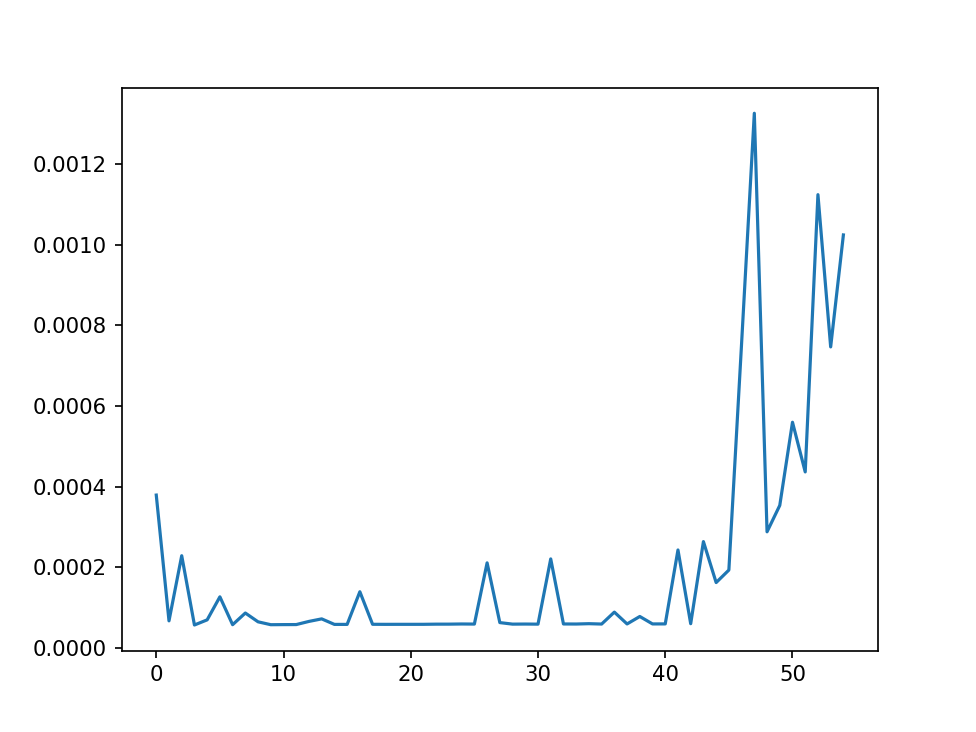

[0, 2, 5, 16, 26, 31, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]


In [20]:
residuals_32p_org=data_org[:,:,2]
rms_chns_org=np.ndarray(residuals_32p_org.shape[1])
chn_remove_org=[]
for i in range(residuals_32p_org.shape[1]):
    rms_chns_org[i]=np.std(residuals_32p_org[:,i])
    if (rms_chns_org[i]> 0.0001):
        chn_remove_org.append(i)
plt.figure()
plt.plot(rms_chns_org)
print(chn_remove_org)
len(chn_remove_org)

## Remove channels_org #######
residuals_32p_org=np.delete(residuals_32p_org,[0, 2, 5, 16, 26, 31, 34, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54],1)

In [21]:
rem_int_org=[]
#print([np.absolute(a)>0.0003 for a in residuals_32p_org[428][:]])
for i in range(residuals_32p_org.shape[0]):
    if np.any([np.absolute(a)>0.0003 for a in residuals_32p_org[i][:]]):
        rem_int_org.append(i)
        
#print(rem_int_org)

## Remoce Integrations ###
residuals_32p_org=np.delete(residuals_32p_org,[36, 89, 107, 147, 150, 175, 183, 233, 320, 395, 428, 724, 776, 840, 844, 857, 859, 938, 960, 961],0)

(946, 35)


<IPython.core.display.Javascript object>


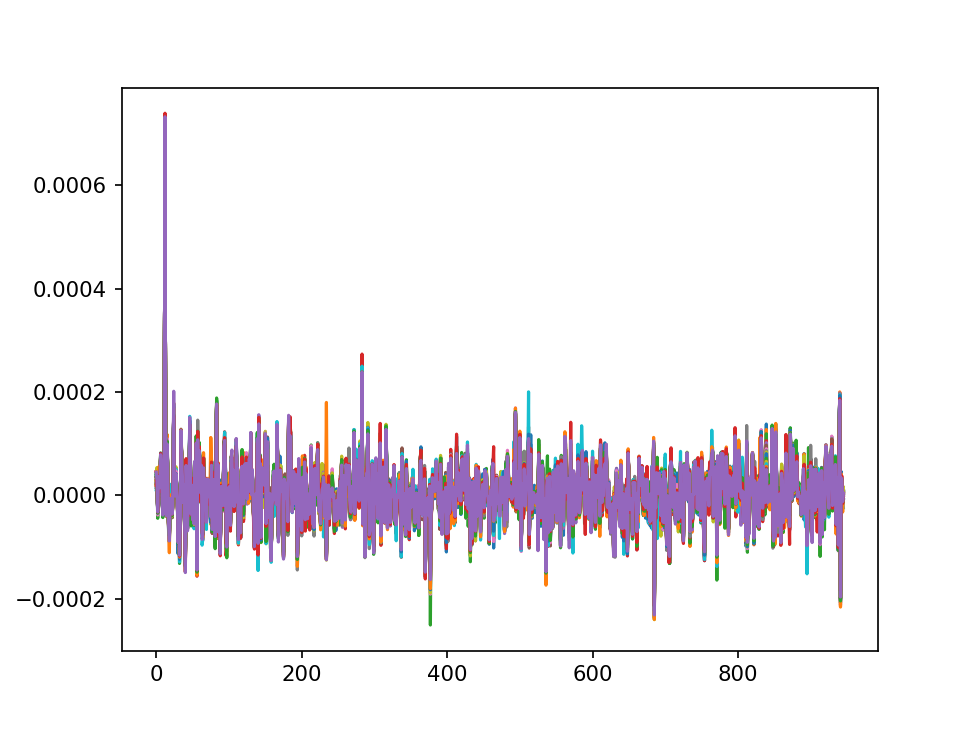

In [22]:
print(residuals_32p_org.shape)
plt.figure()
plt.plot(residuals_32p_org)
#plt.plot(residuals_32p_org[0,:])
#plt.plot(residuals_32p_org[325,:])

In [23]:
Chn_Freq_org=data_org[:,:,1]
Chn_Freq_org=np.mean(Chn_Freq_org,axis=0)
Chn_Freq_org=np.delete(Chn_Freq_org,[0, 2, 5, 16, 26, 31, 34, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54])
Chn_Freq_org.shape
print(Chn_Freq_org)

[ 836.59381571  932.00013251  996.         1112.         1152.
 1236.         1314.         1370.         1406.         1444.
 1506.         1668.         1701.99994792 1876.00009965 1928.
 1968.4        2030.         2075.777778   2134.         2190.46702209
 2234.8        2280.         2517.9999119  2545.55901783 2592.
 2712.         2810.         2850.         2966.         3034.
 3070.         3108.         3176.         3224.         3330.        ]


In [24]:
for a in [0, 2, 5, 16, 26, 31, 34, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]:
    print(data_org[0,a,0])


1.0
3.0
6.0
20.0
32.0
39.0
42.0
49.0
51.0
52.0
53.0
54.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0


In [25]:
#### Running bootstrap on residuals_32p_org to generate samples
with NumpyRNGContext(1):   
    bootresult_32p_org = ast.bootstrap(residuals_32p_org, 500)

<IPython.core.display.Javascript object>


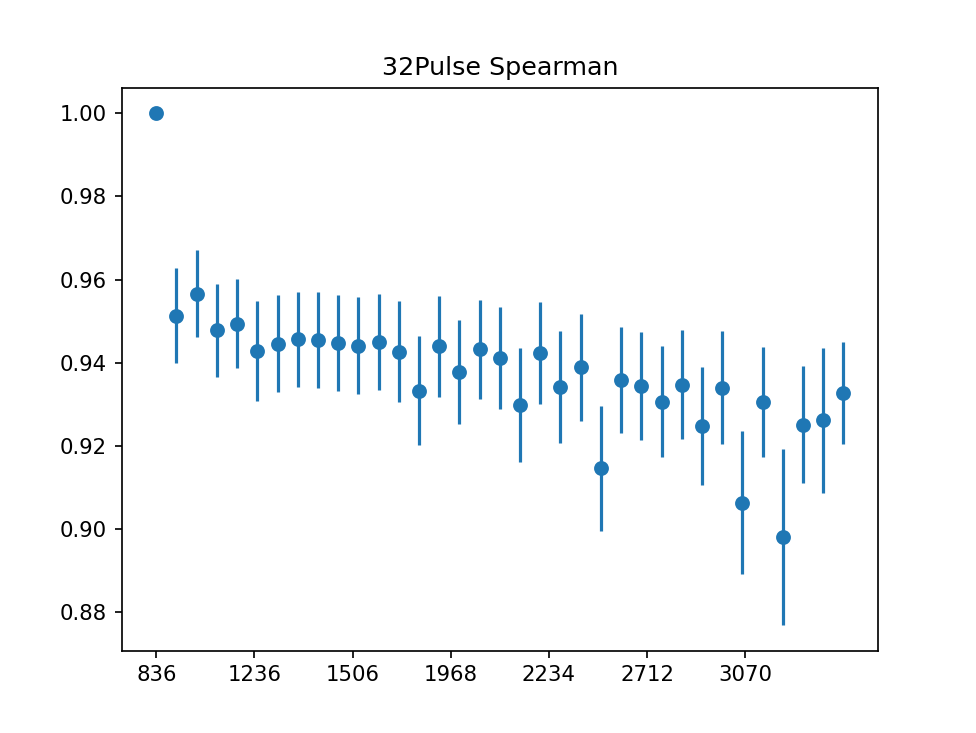

In [26]:
################### Spearman Correlation coefficient ##########

R_32p_spr_org=np.ndarray([bootresult_32p_org.shape[0],bootresult_32p_org.shape[2],bootresult_32p_org.shape[2]])
R_32p_spr_org_pval=np.ndarray([bootresult_32p_org.shape[0],bootresult_32p_org.shape[2],bootresult_32p_org.shape[2]])

for i in range(bootresult_32p_org.shape[0]):
    R_32p_spr_org[i,:,:]=scs.spearmanr(bootresult_32p_org[i,:,:],axis=0)[0]
    R_32p_spr_org_pval[i,:,:]=scs.spearmanr(bootresult_32p_org[i,:,:],axis=0)[1]

plt.figure()
plt.errorbar(np.linspace(0,residuals_32p_org.shape[1],num=residuals_32p_org.shape[1]),np.mean(R_32p_spr_org[:,0,:],axis=0),yerr=1.96*(np.std(R_32p_spr_org[:,0,:],axis=0)),fmt='o')
plt.xticks([0,5,10,15,20,25,30],[int(Chn_Freq_org[5*i]) for i in range(7)])
plt.title("32Pulse Spearman")
plt.show()

#os.chdir(cwd)

<IPython.core.display.Javascript object>


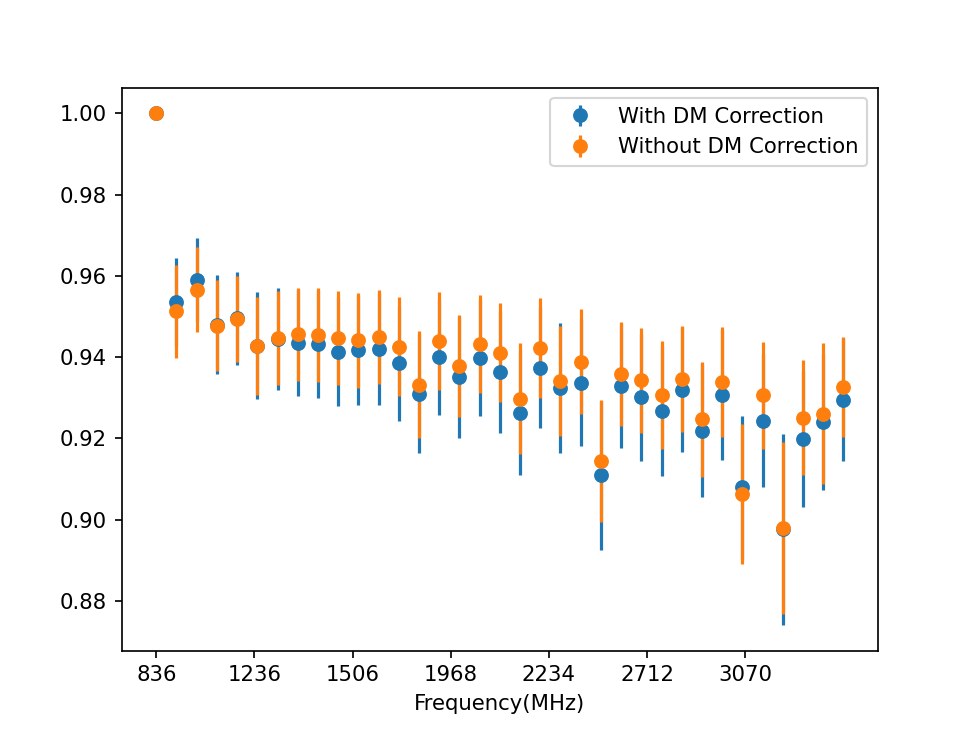

In [27]:
plt.figure()
plt.errorbar(np.linspace(0,residuals_32p.shape[1],num=residuals_32p.shape[1]),np.mean(R_32p_spr[:,0,:],axis=0),yerr=1.96*(np.std(R_32p_spr[:,0,:],axis=0)),fmt='o',label="With DM Correction")
plt.errorbar(np.linspace(0,residuals_32p_org.shape[1],num=residuals_32p_org.shape[1]),np.mean(R_32p_spr_org[:,0,:],axis=0),yerr=1.96*(np.std(R_32p_spr_org[:,0,:],axis=0)),fmt='o',label="Without DM Correction")
plt.xlabel("Frequency(MHz)")
plt.xticks([0,5,10,15,20,25,30],[int(Chn_Freq_org[5*i]) for i in range(7)])
plt.legend()

### 32 pulses with DM Corrected template Removed Channels

In [85]:
cwd = os.getcwd()
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_UWL_01Aug_22/Processed/phase_shifted/timfiles')

In [86]:
df_RmdChn = pd.read_csv('PostRes_32pulint_SelChn_Chan_all.txt', delim_whitespace=True)

#df_RmdChn.iloc[0:55]

In [87]:
data_RmdChn=df_RmdChn.to_numpy()

In [88]:
data_RmdChn=data_RmdChn.reshape((-1,35,4))

In [89]:
channels_RmdChn=data_RmdChn[0,:,0]
#print(channels_RmdChn)
count = 0
for i in range(data_RmdChn.shape[0]):
    if not (data_RmdChn[i,:,0] == channels_RmdChn).all:
        count += 1
print(count)

0


In [90]:
residuals_32p_RmdChn=data_RmdChn[:,:,2]

residuals_32p_RmdChn=data_RmdChn[:,:,2]
rms_chns_RmdChn=np.ndarray(residuals_32p_RmdChn.shape[1])
chn_remove_RmdChn=[]
for i in range(residuals_32p_RmdChn.shape[1]):
    rms_chns_RmdChn[i]=np.std(residuals_32p_RmdChn[:,i])
    if (rms_chns_RmdChn[i]> 0.0001):
        chn_remove_RmdChn.append(i)
plt.figure()
plt.plot(rms_chns_RmdChn)
print(chn_remove_RmdChn)
len(chn_remove_RmdChn)

####### Remove channels_RmdChn #######
residuals_32p_RmdChn=np.delete(residuals_32p_RmdChn,[0, 2, 5, 16, 26, 31, 34, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54],1)

In [96]:
rem_int_RmdChn=[]
#print([np.absolute(a)>0.0003 for a in residuals_32p_RmdChn[428][:]])
for i in range(residuals_32p_RmdChn.shape[0]):
    if np.any([np.absolute(a)>0.0001 for a in residuals_32p_RmdChn[i][:]]):
        rem_int_RmdChn.append(i)
        
print(rem_int_RmdChn)

## Remoce Integrations ###
residuals_32p_RmdChn=np.delete(residuals_32p_RmdChn,[36, 89, 107, 147, 150, 175, 183, 233, 320, 395, 428, 724, 776, 840, 844, 857, 859, 938, 960, 961],0)
#residuals_32p_RmdChn=np.delete(residuals_32p_RmdChn,[75, 87, 88, 104, 145, 169, 176, 225, 230, 234, 311, 385, 417, 585, 689, 712, 763, 826, 829, 841, 842, 891, 941],0)

[76, 89, 90, 107, 150, 175, 183, 233, 238, 242, 320, 395, 428, 596, 700, 724, 776, 840, 844, 857, 859, 960, 961]


(946, 35)


<IPython.core.display.Javascript object>


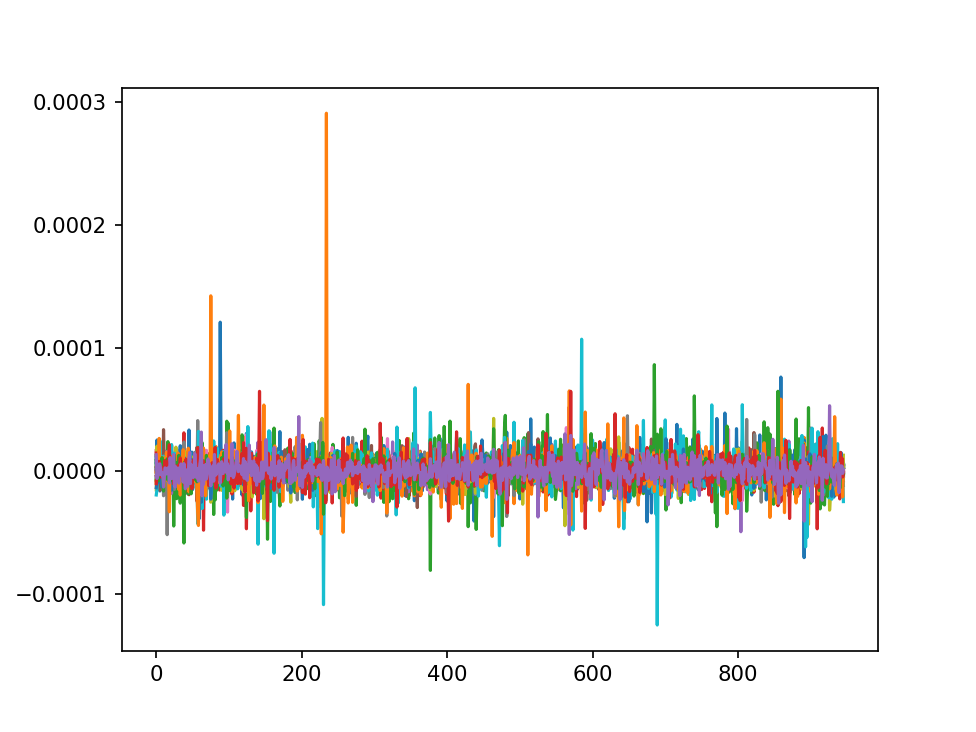

In [97]:
print(residuals_32p_RmdChn.shape)
plt.figure()
plt.plot(residuals_32p_RmdChn)
#plt.plot(residuals_32p_RmdChn[0,:])
#plt.plot(residuals_32p_RmdChn[325,:])

In [98]:
Chn_Freq_RmdChn=data_RmdChn[:,:,1]
Chn_Freq_RmdChn=np.mean(Chn_Freq_RmdChn,axis=0)
#Chn_Freq_RmdChn=np.delete(Chn_Freq_RmdChn,[0, 2, 5, 16, 26, 31, 34, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54])
#Chn_Freq_RmdChn.shape
#print(Chn_Freq_RmdChn)

In [99]:
#### Running bootstrap on residuals_32p_RmdChn to generate samples
with NumpyRNGContext(1):   
    bootresult_32p_RmdChn = ast.bootstrap(residuals_32p_RmdChn, 500)

<IPython.core.display.Javascript object>


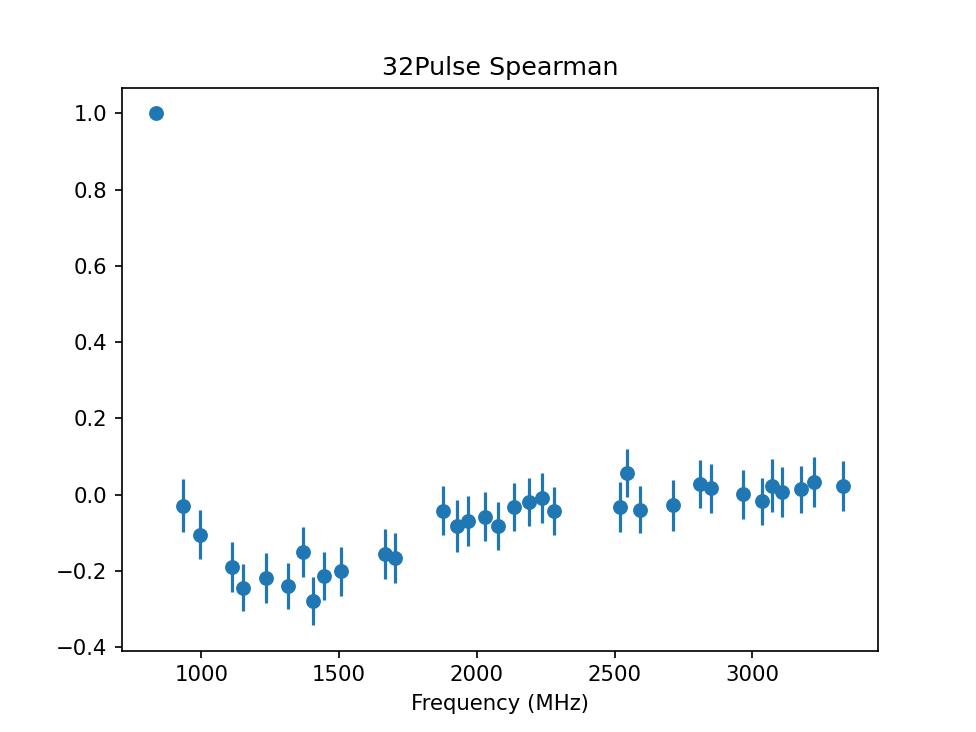

In [100]:
################### Spearman Correlation coefficient ##########

R_32p_spr_RmdChn=np.ndarray([bootresult_32p_RmdChn.shape[0],bootresult_32p_RmdChn.shape[2],bootresult_32p_RmdChn.shape[2]])
R_32p_spr_RmdChn_pval=np.ndarray([bootresult_32p_RmdChn.shape[0],bootresult_32p_RmdChn.shape[2],bootresult_32p_RmdChn.shape[2]])

for i in range(bootresult_32p_RmdChn.shape[0]):
    R_32p_spr_RmdChn[i,:,:]=scs.spearmanr(bootresult_32p_RmdChn[i,:,:],axis=0)[0]
    R_32p_spr_RmdChn_pval[i,:,:]=scs.spearmanr(bootresult_32p_RmdChn[i,:,:],axis=0)[1]

plt.figure()
plt.errorbar(Chn_Freq_RmdChn,np.mean(R_32p_spr_RmdChn[:,0,:],axis=0),yerr=1.96*(np.std(R_32p_spr_RmdChn[:,0,:],axis=0)),fmt='o')
#plt.xticks([0,5,10,15,20,25,30],[int(Chn_Freq_RmdChn[5*i]) for i in range(7)])
plt.title("32Pulse Spearman")
plt.xlabel("Frequency (MHz)")
plt.show()

#os.chdir(cwd)

# DM variation for 4Pulse Integrated data 

In [2]:
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_UWL_01Aug_22/Processed/phase_shifted')

DM_chi_4p=np.genfromtxt("DM_chi_4pulInt_all.txt")  # data containing "DM DM_err Chi_sqr" as a table

##Counting good DM alues######
count=0
for m in range(DM_chi_4p.shape[0]):
    if ( DM_chi_4p[m,2] <101):
        count=count+1

DM_good_4p=np.ndarray([count,count])  # Create a new dataset to store good DM

####### Taking DM values for which Chi_sqr is less than 100####################
count=0
for m in range(DM_chi_4p.shape[0]):
    if ( DM_chi_4p[m,2] <101):
        DM_good_4p[count,0]=DM_chi_4p[m,0]
        DM_good_4p[count,1]=DM_chi_4p[m,1]
        count=count+1
        

<IPython.core.display.Javascript object>


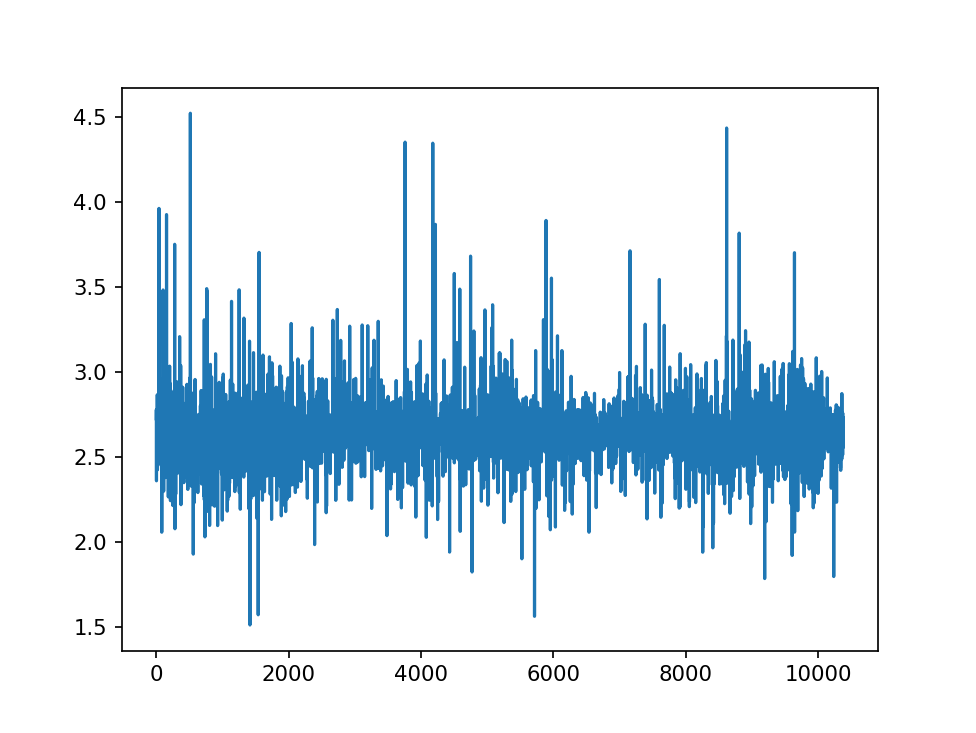

In [3]:
plt.figure();
plt.plot(DM_chi_4p[:,0])


In [4]:
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_UWL_01Aug_22/Processed/phase_shifted')

DM_chi_Select5_4p=np.genfromtxt("DM_chi_Select5_4pulInt_all.txt")  # data containing "DM DM_err Chi_sqr" as a table

##Counting good DM alues######
count=0
for m in range(DM_chi_Select5_4p.shape[0]):
    if ( DM_chi_Select5_4p[m,2] <101):
        count=count+1

DM_good_Select5_4p=np.ndarray([count,count])  # Create a new dataset to store good DM

####### Taking DM values for which Chi_sqr is less than 100####################
count=0
for m in range(DM_chi_Select5_4p.shape[0]):
    if ( DM_chi_Select5_4p[m,2] <101):
        DM_good_Select5_4p[count,0]=DM_chi_Select5_4p[m,0]
        DM_good_Select5_4p[count,1]=DM_chi_Select5_4p[m,1]
        count=count+1
        

<IPython.core.display.Javascript object>


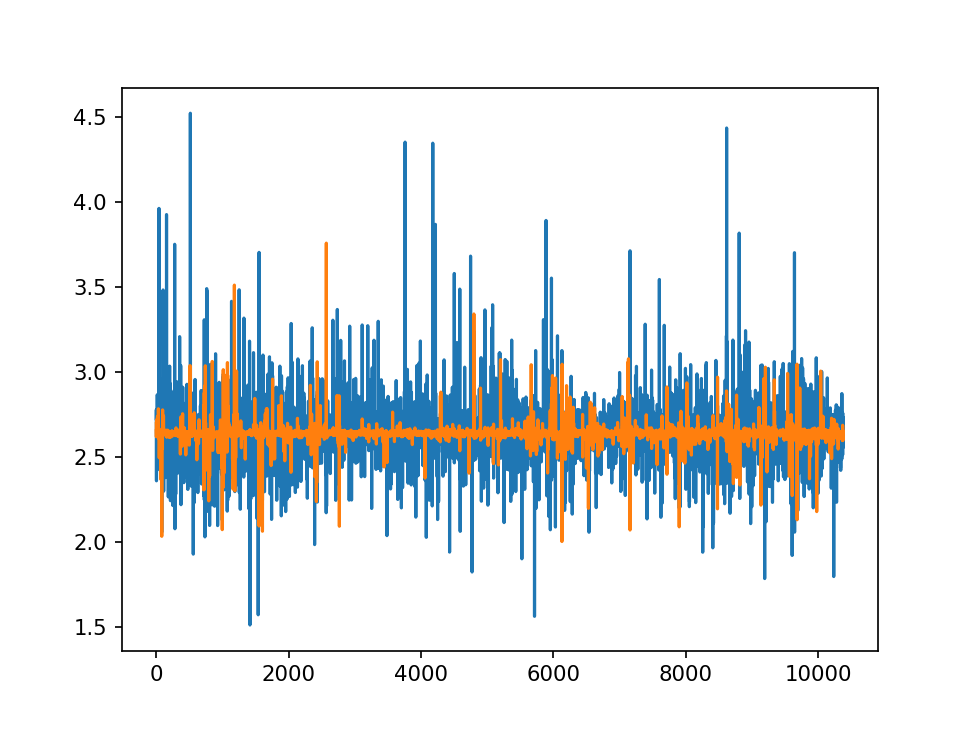

In [6]:
plt.figure();
plt.plot(DM_chi_4p[:,0])
plt.plot(DM_chi_Select5_4p[:,0])


Deleting DM values at the following locations as they are outliers caused due to bad data

In [4]:
DM_chi_4p=np.delete(DM_chi_4p,[4300,4301,4305,4312,4313,4316,4317,5419,7294],0)
DM_chi_4p.shape

(10991, 4)

<IPython.core.display.Javascript object>


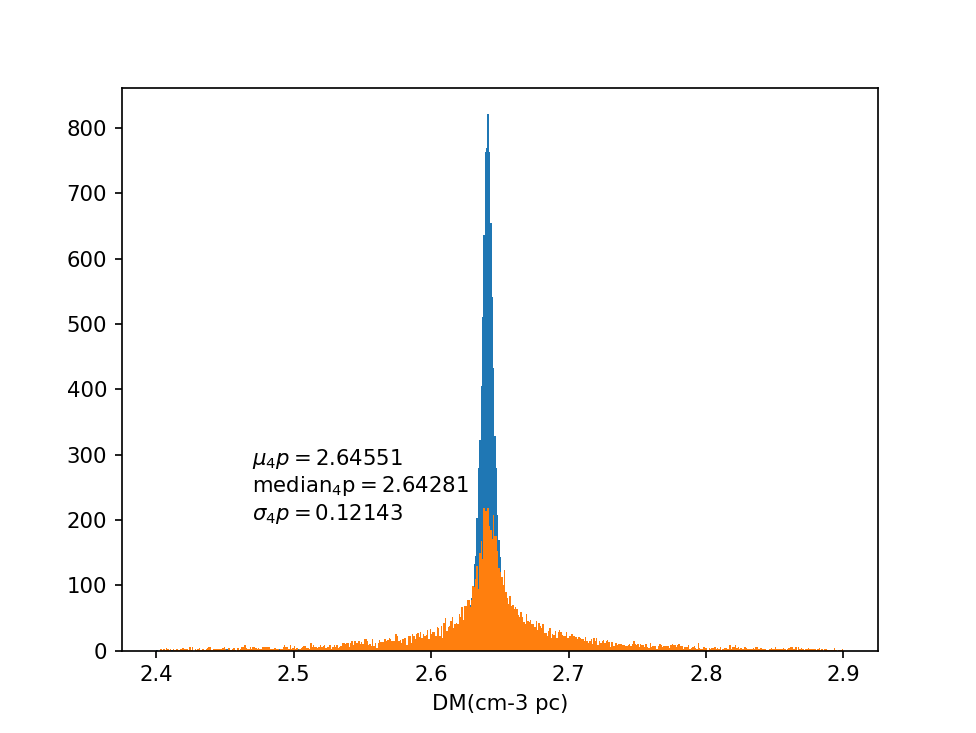

In [10]:

Fig, Axs = plt.subplots()

mu_4p=np.mean((DM_chi_4p[:,0]));
median_4p=np.median((DM_chi_4p[:,0]))
sigma_4p=np.std(DM_chi_4p[:,0])
textstr = '\n'.join((r'$\mu_4p=%.5f$' % (mu_4p, ),r'$\mathrm{median_4p}=%.5f$' % (median_4p, ),r'$\sigma_4p=%.5f$' % (sigma_4p, )))


Axs.hist(DM_chi_Select5_4p[:,0],bins=500,range=(2.4, 2.9))
Axs.hist(DM_chi_4p[:,0],bins=500,range=(2.4, 2.9))
Axs.set_xlabel('DM(cm-3 pc)')
Axs.text(2.47, 200, textstr)
plt.show()

# DM variation for 8 pulse integrated data

In [6]:
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed')

DM_chi_8p=np.genfromtxt("DM_chi_withk_8pulInt_all.txt")  # data containing "DM DM_err Chi_sqr" as a table

##Counting good DM alues######
count=0
for m in range(DM_chi_8p.shape[0]):
    if ( DM_chi_8p[m,2] <101):
        count=count+1

DM_good=np.ndarray([count,count])  # Create a new dataset to store good DM

####### Taking DM values for which Chi_sqr is less than 100####################
count=0
for m in range(DM_chi_8p.shape[0]):
    if ( DM_chi_8p[m,2] <101):
        DM_good[count,0]=DM_chi_8p[m,0]
        DM_good[count,1]=DM_chi_8p[m,1]
        count=count+1
        

<IPython.core.display.Javascript object>


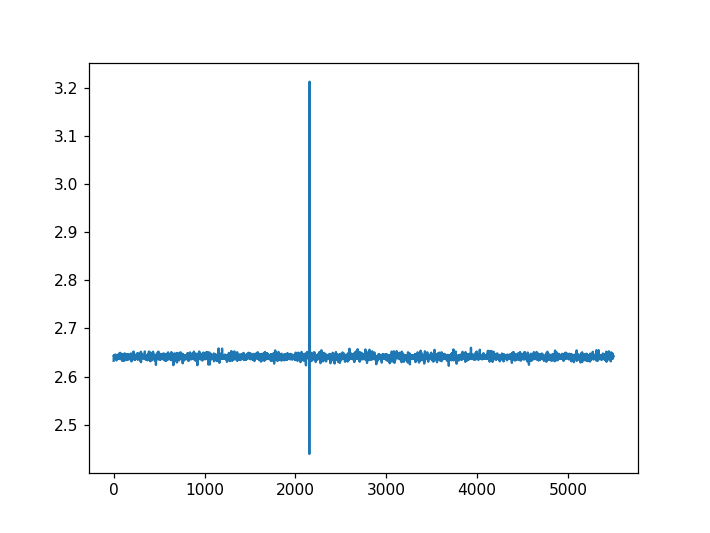

In [7]:
plt.figure();
plt.plot(DM_chi_8p[:,0])


In [8]:
DM_chi_8p=np.delete(DM_chi_8p,[2152,2153,2156,2158],0)
DM_chi_8p.shape

(5496, 4)

<IPython.core.display.Javascript object>


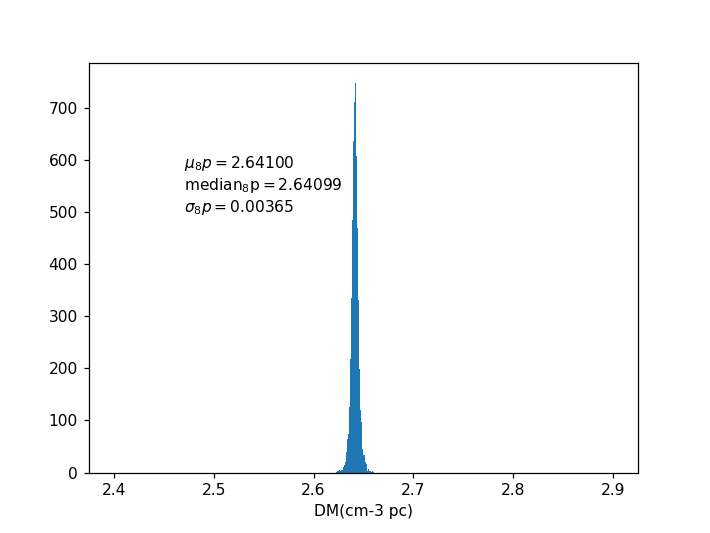

In [9]:

Fig, Axs = plt.subplots()

mu_8p=np.mean((DM_chi_8p[:,0]))
median_8p=np.median((DM_chi_8p[:,0]))
sigma_8p=np.std(DM_chi_8p[:,0])
textstr = '\n'.join((r'$\mu_8p=%.5f$' % (mu_8p, ),r'$\mathrm{median_8p}=%.5f$' % (median_8p, ),r'$\sigma_8p=%.5f$' % (sigma_8p, )))

Axs.hist(DM_chi_8p[:,0],bins=500,range=(2.4, 2.9))
Axs.set_xlabel('DM(cm-3 pc)')
Axs.text(2.47, 500, textstr)
plt.show()

# DM Variation for 16 pulse Subintegration

In [10]:
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed')

DM_chi_16p=np.genfromtxt("DM_chi_withk_16pulInt_all.txt")  # data containing "DM DM_err Chi_sqr" as a table

##Counting good DM alues######
count=0
for m in range(DM_chi_16p.shape[0]):
    if ( DM_chi_16p[m,2] <101):
        count=count+1

DM_good=np.ndarray([count,count])  # Create a new dataset to store good DM

####### Taking DM values for which Chi_sqr is less than 100####################
count=0
for m in range(DM_chi_16p.shape[0]):
    if ( DM_chi_16p[m,2] <101):
        DM_good[count,0]=DM_chi_16p[m,0]
        DM_good[count,1]=DM_chi_16p[m,1]
        count=count+1
        

<IPython.core.display.Javascript object>


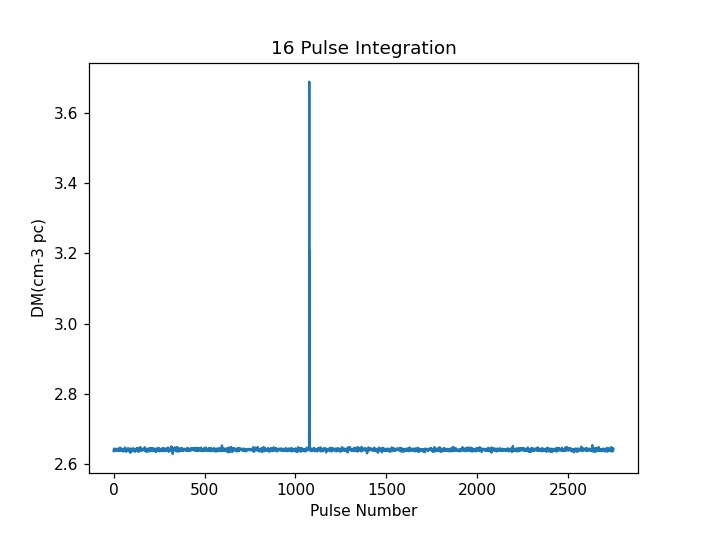

<IPython.core.display.Javascript object>


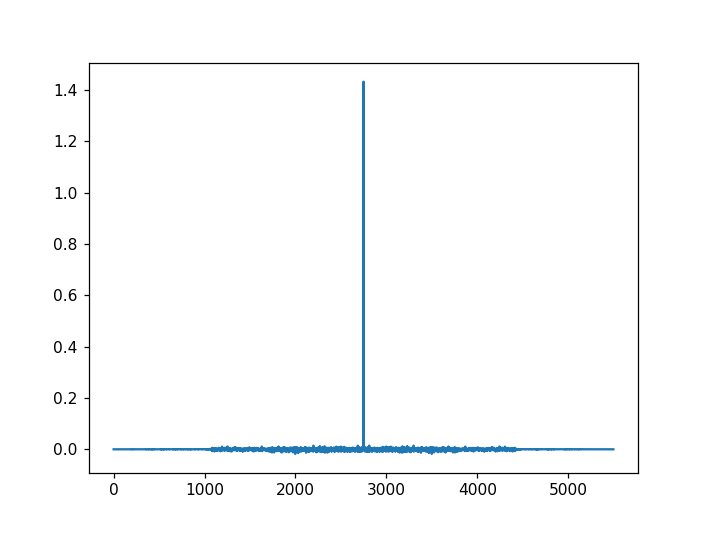

In [11]:
plt.figure();
plt.plot(DM_chi_16p[:,0])
plt.title('16 Pulse Integration')
plt.xlabel('Pulse Number')
plt.ylabel('DM(cm-3 pc)')
plt.figure()
plt.plot(np.correlate(DM_chi_16p[:,0]-np.mean(DM_chi_16p[:,0]),DM_chi_16p[:,0]-np.mean(DM_chi_16p[:,0]),"full"))

In [12]:
DM_chi_16p=np.delete(DM_chi_16p,[1076,1078],0)
DM_chi_16p.shape

(2748, 4)

<IPython.core.display.Javascript object>


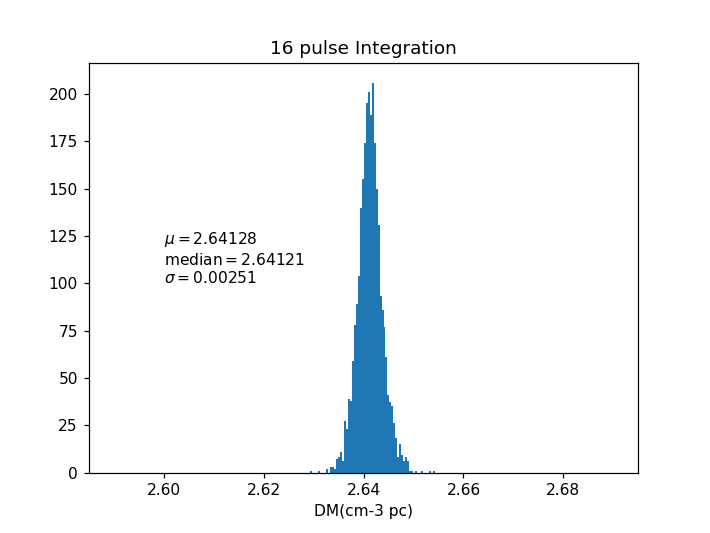

Text(2.6, 100, '$\\mu=2.64128$\n$\\mathrm{median}=2.64121$\n$\\sigma=0.00251$')

In [13]:

Fig_16p, Axs_16p = plt.subplots()

mu_16p=np.mean((DM_chi_16p[:,0]))
median_16p=np.median((DM_chi_16p[:,0]))
sigma_16p=np.std(DM_chi_16p[:,0])
textstr = '\n'.join((r'$\mu=%.5f$' % (mu_16p, ),r'$\mathrm{median}=%.5f$' % (median_16p, ),r'$\sigma=%.5f$' % (sigma_16p, )))

Axs_16p.hist(DM_chi_16p[:,0],bins=250,range=(2.59, 2.69))
Axs_16p.set_xlabel('DM(cm-3 pc)')
Axs_16p.set_title('16 pulse Integration')
Axs_16p.text(2.60, 100, textstr)
#plt.show()

# DM Variation for 32 pulse Integration

In [14]:
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed')

DM_chi_32p=np.genfromtxt("DM_chi_withk_32pulInt_all.txt")  # data containing "DM DM_err Chi_sqr" as a table

##Counting good DM alues######
count=0
for m in range(DM_chi_32p.shape[0]):
    if ( DM_chi_32p[m,2] <101):
        count=count+1

DM_good=np.ndarray([count,count])  # Create a new dataset to store good DM

####### Taking DM values for which Chi_sqr is less than 100####################
count=0
for m in range(DM_chi_32p.shape[0]):
    if ( DM_chi_32p[m,2] <101):
        DM_good[count,0]=DM_chi_32p[m,0]
        DM_good[count,1]=DM_chi_32p[m,1]
        count=count+1
        

<IPython.core.display.Javascript object>


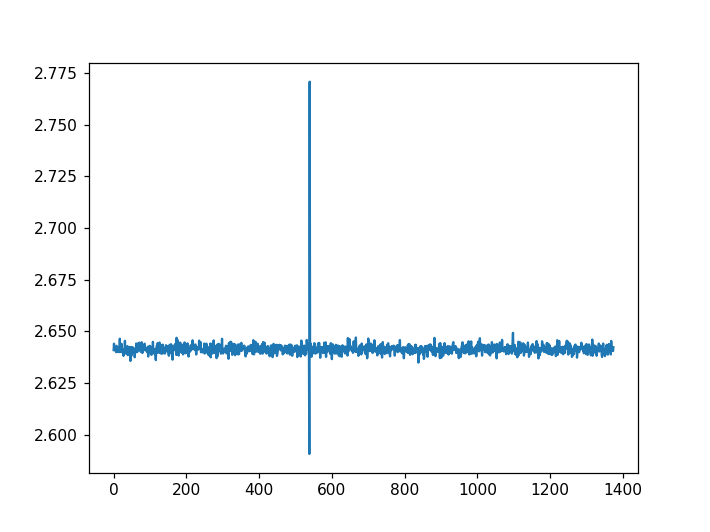

In [15]:
plt.figure();
plt.plot(DM_chi_32p[:,0])


In [16]:
DM_chi_32p=np.delete(DM_chi_32p,[538,539],0)
DM_chi_32p.shape

(1373, 4)

<IPython.core.display.Javascript object>


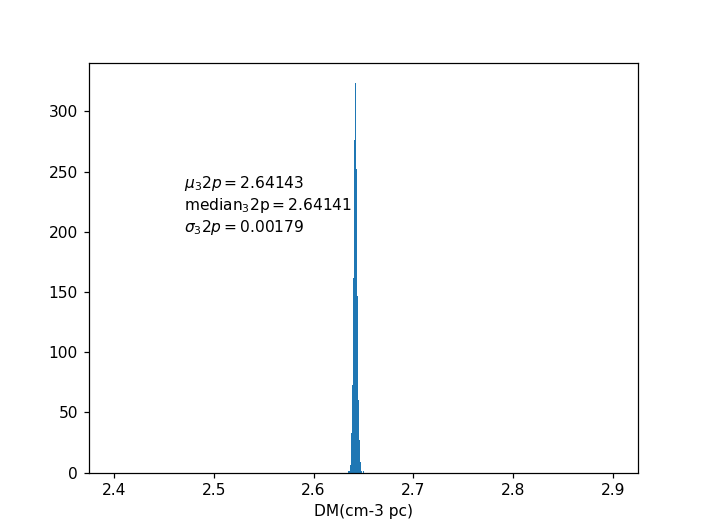

In [17]:

Fig, Axs = plt.subplots()

mu_32p=np.mean((DM_chi_32p[:,0]))
median_32p=np.median((DM_chi_32p[:,0]))
sigma_32p=np.std(DM_chi_32p[:,0])
textstr = '\n'.join((r'$\mu_32p=%.5f$' % (mu_32p, ),r'$\mathrm{median_32p}=%.5f$' % (median_32p, ),r'$\sigma_32p=%.5f$' % (sigma_32p, )))

Axs.hist(DM_chi_32p[:,0],bins=500,range=(2.4, 2.9))
Axs.set_xlabel('DM(cm-3 pc)')
Axs.text(2.47, 200, textstr)
plt.show()

# DM Variation for 64 pulse Integration

In [18]:
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed')

DM_chi_64p=np.genfromtxt("DM_chi_withk_64pulInt_all.txt")  # data containing "DM DM_err Chi_sqr" as a table

##Counting good DM alues######
count=0
for m in range(DM_chi_64p.shape[0]):
    if ( DM_chi_64p[m,2] <101):
        count=count+1

DM_good=np.ndarray([count,count])  # Create a new dataset to store good DM

####### Taking DM values for which Chi_sqr is less than 100####################
count=0
for m in range(DM_chi_64p.shape[0]):
    if ( DM_chi_64p[m,2] <101):
        DM_good[count,0]=DM_chi_64p[m,0]
        DM_good[count,1]=DM_chi_64p[m,1]
        count=count+1
        

<IPython.core.display.Javascript object>


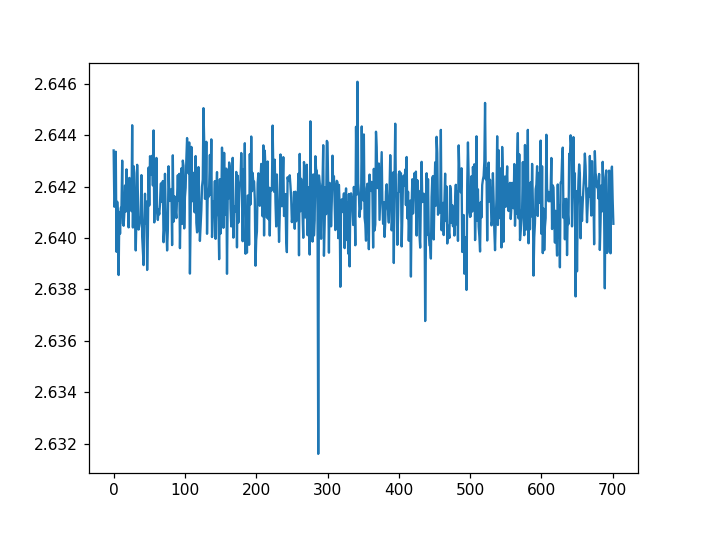

In [19]:
plt.figure();
plt.plot(DM_chi_64p[:,0])
#plt.hlines([mu_64p],0,700,color='r')

In [20]:
DM_chi_64p=np.delete(DM_chi_64p,[287],0)
DM_chi_64p.shape

(701, 4)

<IPython.core.display.Javascript object>


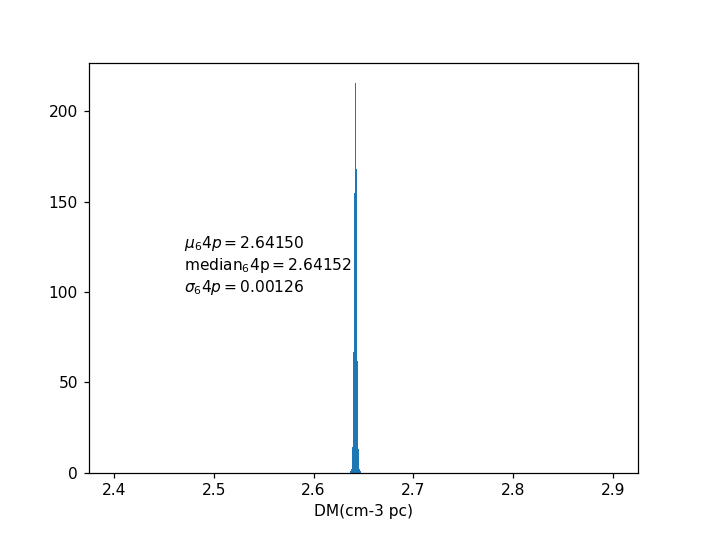

In [21]:

Fig, Axs = plt.subplots()

mu_64p=np.mean((DM_chi_64p[:,0]))
median_64p=np.median((DM_chi_64p[:,0]))
sigma_64p=np.std(DM_chi_64p[:,0])
textstr = '\n'.join((r'$\mu_64p=%.5f$' % (mu_64p, ),r'$\mathrm{median_64p}=%.5f$' % (median_64p, ),r'$\sigma_64p=%.5f$' % (sigma_64p, )))

Axs.hist(DM_chi_64p[:,0],bins=500,range=(2.4, 2.9))
Axs.set_xlabel('DM(cm-3 pc)')
Axs.text(2.47, 100, textstr)
plt.show()

# DM Variation for 128 pulse Integration

In [22]:
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed')

DM_chi_128p=np.genfromtxt("DM_chi_withk_128pulInt_all.txt")  # data containing "DM DM_err Chi_sqr" as a table

##Counting good DM alues######
count=0
for m in range(DM_chi_128p.shape[0]):
    if ( DM_chi_128p[m,2] <101):
        count=count+1

DM_good=np.ndarray([count,count])  # Create a new dataset to store good DM

####### Taking DM values for which Chi_sqr is less than 100####################
count=0
for m in range(DM_chi_128p.shape[0]):
    if ( DM_chi_128p[m,2] <101):
        DM_good[count,0]=DM_chi_128p[m,0]
        DM_good[count,1]=DM_chi_128p[m,1]
        count=count+1
        

<IPython.core.display.Javascript object>


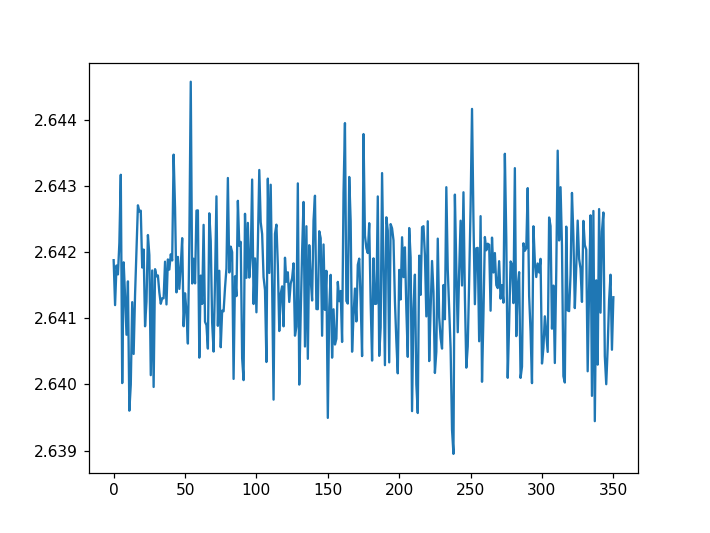

<IPython.core.display.Javascript object>


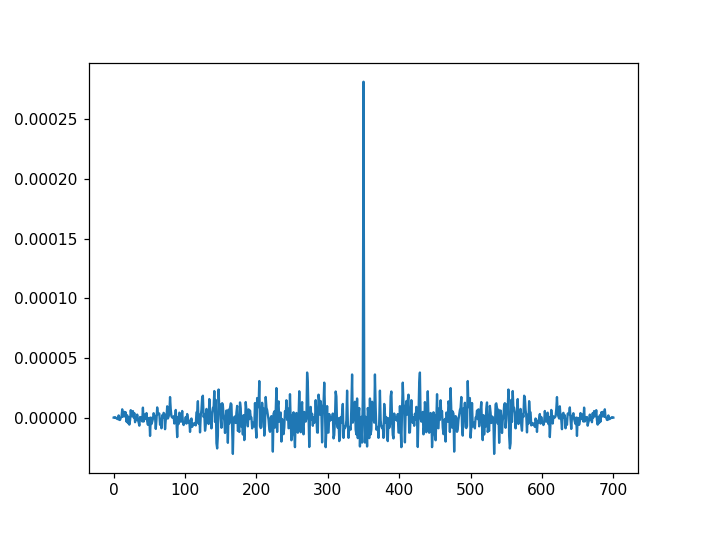

In [23]:
plt.figure();
plt.plot(DM_chi_128p[:,0])
#plt.hlines([mu_128p],0,700,color='r')
plt.figure()
plt.plot(np.correlate(DM_chi_128p[:,0]-np.mean(DM_chi_128p[:,0]),DM_chi_128p[:,0]-np.mean(DM_chi_128p[:,0]),"full"))

In [24]:
#DM_chi_128p=np.delete(DM_chi_128p,[287],0)
DM_chi_128p.shape

(351, 4)

<IPython.core.display.Javascript object>


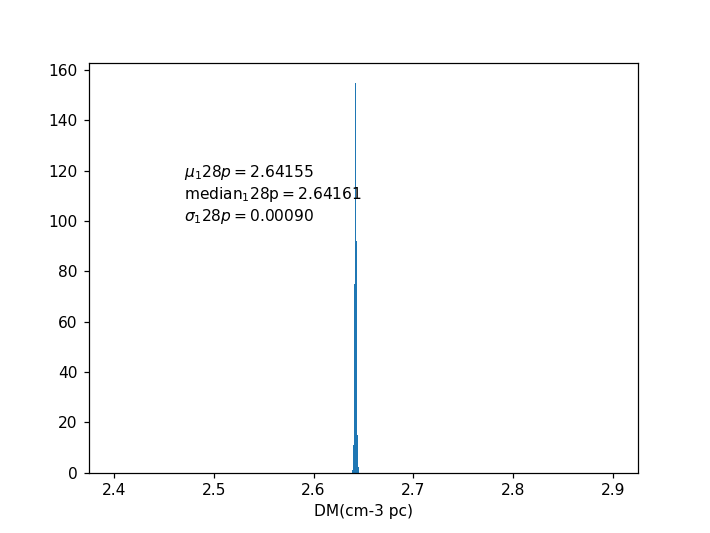

In [25]:

Fig, Axs = plt.subplots()

mu_128p=np.mean((DM_chi_128p[:,0]))
median_128p=np.median((DM_chi_128p[:,0]))
sigma_128p=np.std(DM_chi_128p[:,0])
textstr = '\n'.join((r'$\mu_128p=%.5f$' % (mu_128p, ),r'$\mathrm{median_128p}=%.5f$' % (median_128p, ),r'$\sigma_128p=%.5f$' % (sigma_128p, )))

Axs.hist(DM_chi_128p[:,0],bins=500,range=(2.4, 2.9))
Axs.set_xlabel('DM(cm-3 pc)')
Axs.text(2.47, 100, textstr)
plt.show()

# DM Variation for 256 pulse Integration

In [26]:
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed')

DM_chi_256p=np.genfromtxt("DM_chi_withk_256pulInt_all.txt")  # data containing "DM DM_err Chi_sqr" as a table

##Counting good DM alues######
count=0
for m in range(DM_chi_256p.shape[0]):
    if ( DM_chi_256p[m,2] <101):
        count=count+1

DM_good=np.ndarray([count,count])  # Create a new dataset to store good DM

####### Taking DM values for which Chi_sqr is less than 100####################
count=0
for m in range(DM_chi_256p.shape[0]):
    if ( DM_chi_256p[m,2] <101):
        DM_good[count,0]=DM_chi_256p[m,0]
        DM_good[count,1]=DM_chi_256p[m,1]
        count=count+1
        

<IPython.core.display.Javascript object>


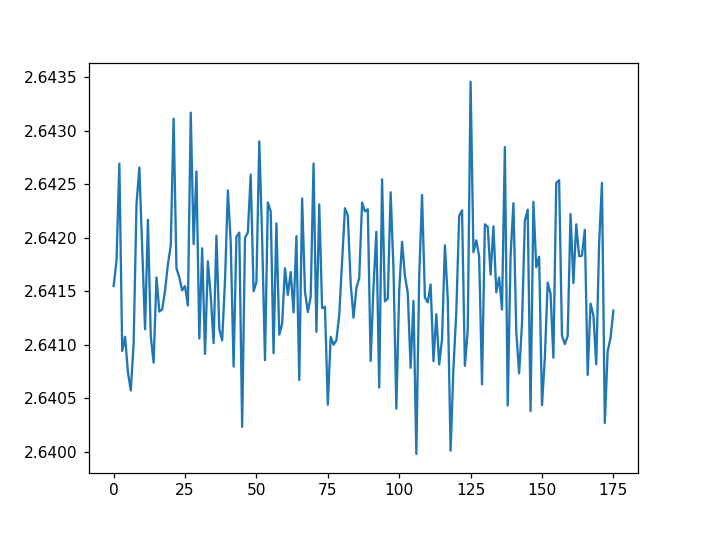

<IPython.core.display.Javascript object>


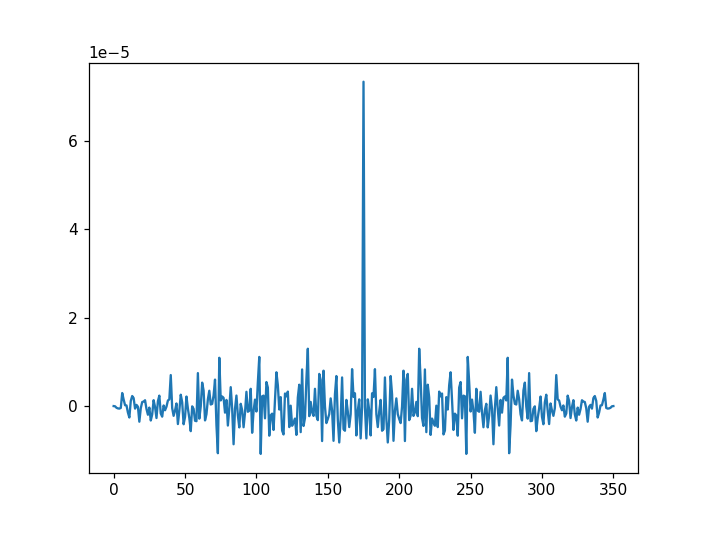

In [27]:
plt.figure();
plt.plot(DM_chi_256p[:,0])
#plt.hlines([mu_256p],0,700,color='r')
plt.figure()
plt.plot(np.correlate(DM_chi_256p[:,0]-np.mean(DM_chi_256p[:,0]),DM_chi_256p[:,0]-np.mean(DM_chi_256p[:,0]),"full"))

In [28]:
#DM_chi_256p=np.delete(DM_chi_256p,[287],0)
DM_chi_256p.shape

(176, 4)

<IPython.core.display.Javascript object>


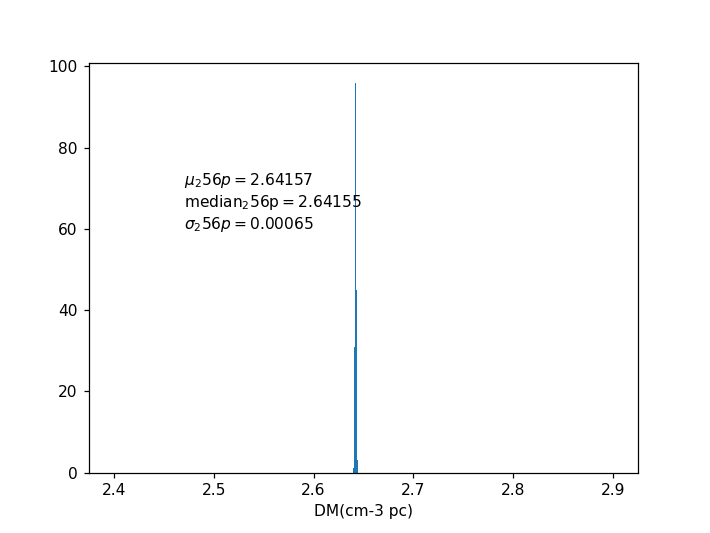

In [29]:

Fig, Axs = plt.subplots()

mu_256p=np.mean((DM_chi_256p[:,0]))
median_256p=np.median((DM_chi_256p[:,0]))
sigma_256p=np.std(DM_chi_256p[:,0])
textstr = '\n'.join((r'$\mu_256p=%.5f$' % (mu_256p, ),r'$\mathrm{median_256p}=%.5f$' % (median_256p, ),r'$\sigma_256p=%.5f$' % (sigma_256p, )))

Axs.hist(DM_chi_256p[:,0],bins=500,range=(2.4, 2.9))
Axs.set_xlabel('DM(cm-3 pc)')
Axs.text(2.47, 60, textstr)
plt.show()

# DM Variation for 512 pulse Integration

In [30]:
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed')

DM_chi_512p=np.genfromtxt("DM_chi_withk_512pulInt_all.txt")  # data containing "DM DM_err Chi_sqr" as a table

##Counting good DM alues######
count=0
for m in range(DM_chi_512p.shape[0]):
    if ( DM_chi_512p[m,2] <101):
        count=count+1

DM_good=np.ndarray([count,count])  # Create a new dataset to store good DM

####### Taking DM values for which Chi_sqr is less than 100####################
count=0
for m in range(DM_chi_512p.shape[0]):
    if ( DM_chi_512p[m,2] <101):
        DM_good[count,0]=DM_chi_512p[m,0]
        DM_good[count,1]=DM_chi_512p[m,1]
        count=count+1
        

<IPython.core.display.Javascript object>


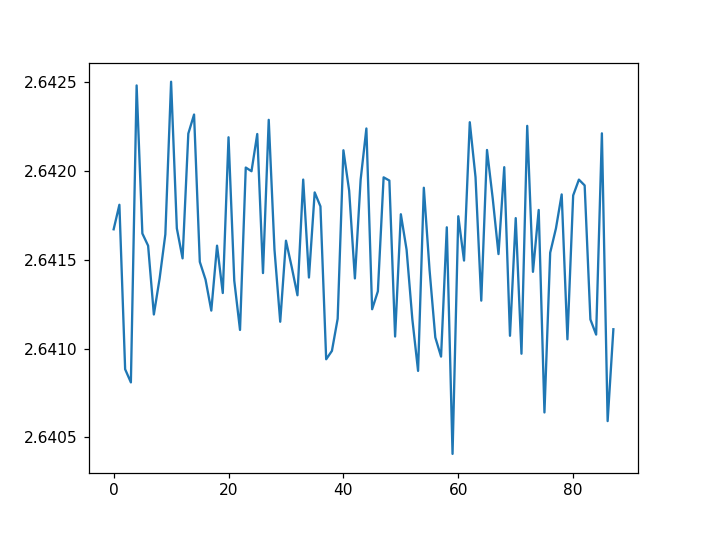

<IPython.core.display.Javascript object>


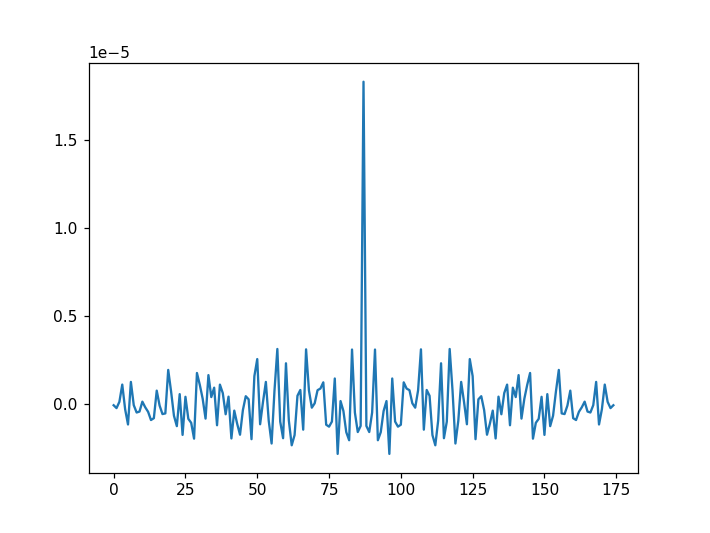

In [31]:
plt.figure();
plt.plot(DM_chi_512p[:,0])
#plt.hlines([mu_512p],0,700,color='r')
plt.figure()
plt.plot(np.correlate(DM_chi_512p[:,0]-np.mean(DM_chi_512p[:,0]),DM_chi_512p[:,0]-np.mean(DM_chi_512p[:,0]),"full"))

In [32]:
#DM_chi_512p=np.delete(DM_chi_512p,[287],0)
DM_chi_512p.shape

(88, 4)

<IPython.core.display.Javascript object>


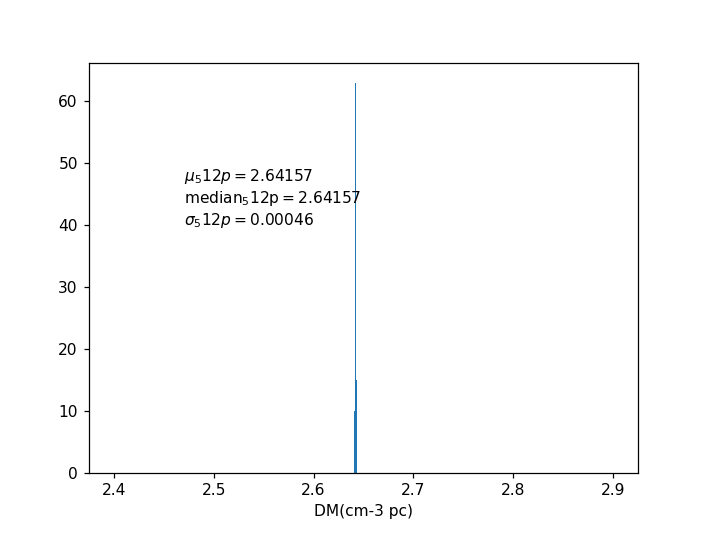

In [33]:

Fig, Axs = plt.subplots()

mu_512p=np.mean((DM_chi_512p[:,0]))
median_512p=np.median((DM_chi_512p[:,0]))
sigma_512p=np.std(DM_chi_512p[:,0])
textstr = '\n'.join((r'$\mu_512p=%.5f$' % (mu_512p, ),r'$\mathrm{median_512p}=%.5f$' % (median_512p, ),r'$\sigma_512p=%.5f$' % (sigma_512p, )))

Axs.hist(DM_chi_512p[:,0],bins=500,range=(2.4, 2.9))
Axs.set_xlabel('DM(cm-3 pc)')
Axs.text(2.47, 40, textstr)
plt.show()

# DM Variation for 1024 pulse Integration

In [34]:
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed')

DM_chi_1024p=np.genfromtxt("DM_chi_withk_1024pulInt_all.txt")  # data containing "DM DM_err Chi_sqr" as a table

##Counting good DM alues######
count=0
for m in range(DM_chi_1024p.shape[0]):
    if ( DM_chi_1024p[m,2] <101):
        count=count+1

DM_good=np.ndarray([count,count])  # Create a new dataset to store good DM

####### Taking DM values for which Chi_sqr is less than 100####################
count=0
for m in range(DM_chi_1024p.shape[0]):
    if ( DM_chi_1024p[m,2] <101):
        DM_good[count,0]=DM_chi_1024p[m,0]
        DM_good[count,1]=DM_chi_1024p[m,1]
        count=count+1
        

/tmp/ipykernel_10194/610305088.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure();


<IPython.core.display.Javascript object>


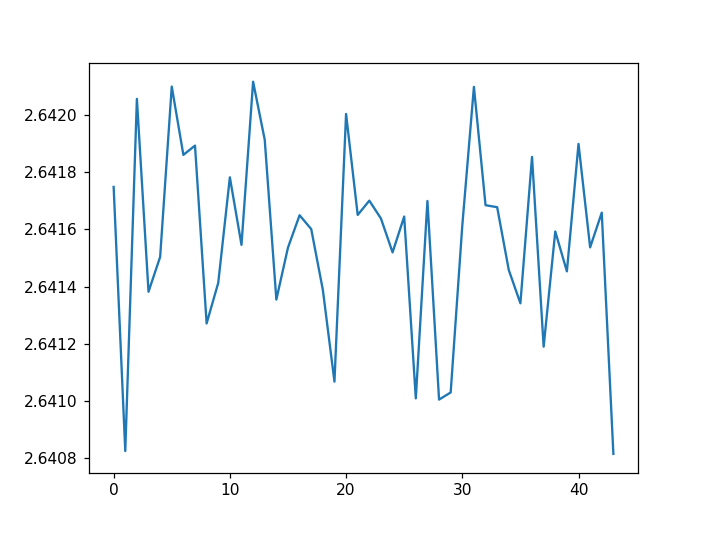

<IPython.core.display.Javascript object>


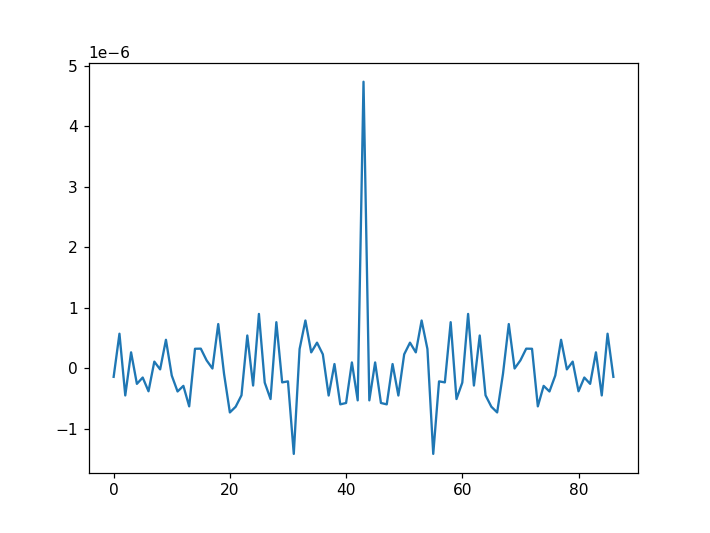

In [35]:
plt.figure();
plt.plot(DM_chi_1024p[:,0])
#plt.hlines([mu_1024p],0,700,color='r')
plt.figure()
plt.plot(np.correlate(DM_chi_1024p[:,0]-np.mean(DM_chi_1024p[:,0]),DM_chi_1024p[:,0]-np.mean(DM_chi_1024p[:,0]),"full"))

In [36]:
#DM_chi_1024p=np.delete(DM_chi_1024p,[287],0)
DM_chi_1024p.shape

(44, 4)

<IPython.core.display.Javascript object>


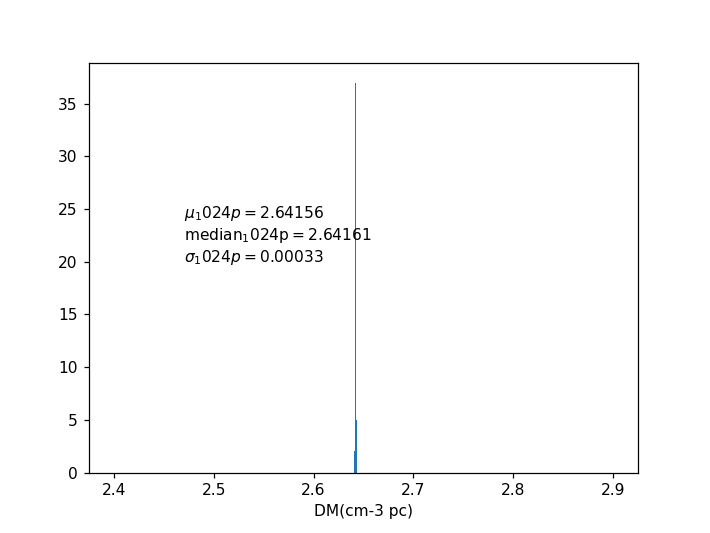

In [37]:

Fig, Axs = plt.subplots()

mu_1024p=np.mean((DM_chi_1024p[:,0]))
median_1024p=np.median((DM_chi_1024p[:,0]))
sigma_1024p=np.std(DM_chi_1024p[:,0])
textstr = '\n'.join((r'$\mu_1024p=%.5f$' % (mu_1024p, ),r'$\mathrm{median_1024p}=%.5f$' % (median_1024p, ),r'$\sigma_1024p=%.5f$' % (sigma_1024p, )))

Axs.hist(DM_chi_1024p[:,0],bins=500,range=(2.4, 2.9))
Axs.set_xlabel('DM(cm-3 pc)')
Axs.text(2.47, 20, textstr)
plt.show()

<IPython.core.display.Javascript object>


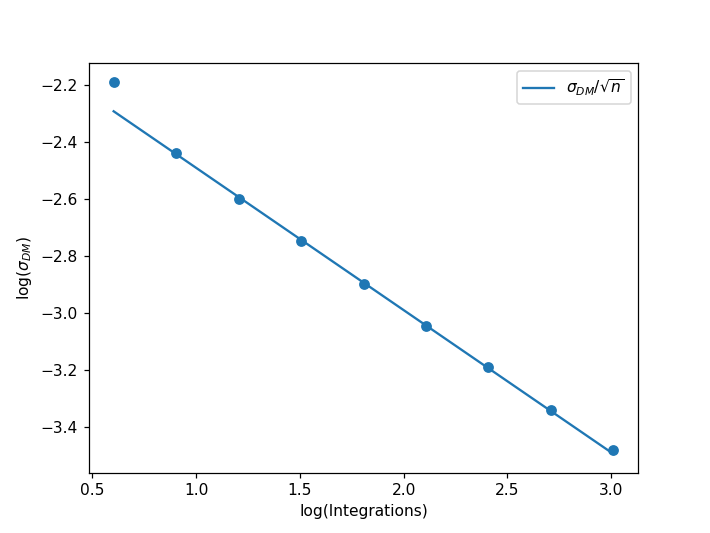

<IPython.core.display.Javascript object>


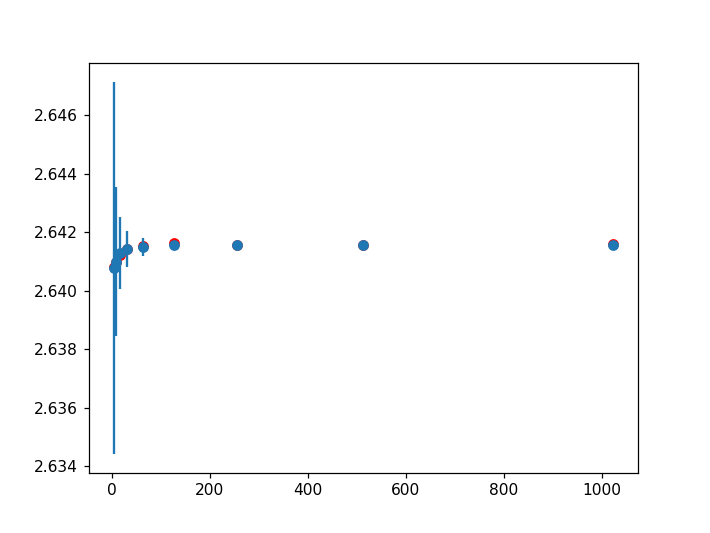

In [38]:
from scipy.optimize import curve_fit

def func(n,sigma_pop):
    return np.divide(sigma_pop,np.sqrt(n))


sigma_array=np.asarray([sigma_4p,sigma_8p,sigma_16p,sigma_32p,sigma_64p,sigma_128p,sigma_256p,sigma_512p,sigma_1024p])
mu_array=np.asarray([mu_4p,mu_8p,mu_16p,mu_32p,mu_64p,mu_128p,mu_256p,mu_512p,mu_1024p])
median_array=np.asarray([median_4p,median_8p,median_16p,median_32p,median_64p,median_128p,median_256p,median_512p,median_1024p])
Integration=np.asarray([4,8,16,32,64,128,256,512,1024])

popt, pcov = curve_fit(func, Integration[1:7], sigma_array[1:7])

plt.figure()
plt.scatter(np.log10(Integration),np.log10(sigma_array))
plt.plot(np.log10(Integration),np.log10(func(Integration,*popt)),label=r'$\sigma_{DM}/\sqrt{n}$')
plt.xlabel('log(Integrations)')
plt.ylabel(r'log($\sigma_{DM}$)')
#plt.title(r'$\sigma_{DM}/\sqrt{n}$')
plt.legend()
plt.figure()
plt.errorbar(Integration,mu_array,yerr=1.96*np.divide(sigma_array,np.sqrt(Integration)),fmt='o')
plt.scatter(Integration,median_array,color='red')

In [39]:
np.sqrt(3600*173.68794566489231762)

790.744335669635

In [41]:
print(func(1,*popt))

0.010206063296353282


# TOA Correlation 

## 4 Pulse Integration

In [12]:
cwd = os.getcwd()
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_UWL_01Aug_22/Processed/phase_shifted/timfiles')

In [13]:
residuals_4p = np.genfromtxt('PostRes_4pulint_all.txt')
residuals_4p.shape

(570955, 3)

In [14]:
chn_list=[]

for i in range(residuals_4p.shape[0]):
    if not (residuals_4p[i,0] in chn_list):
        chn_list.append(residuals_4p[i,0])
        

In [20]:
chn_list.sort()
chn_list[0:80]

[806.0,
 834.0,
 834.941176,
 835.777778,
 836.526316,
 837.2,
 864.0,
 867.777778,
 875.333333,
 932.0,
 932.285714,
 996.0,
 1046.0,
 1046.571429,
 1046.631579,
 1046.666667,
 1046.909091,
 1047.217391,
 1047.28,
 1047.333333,
 1047.76,
 1047.818182,
 1048.0,
 1048.117647,
 1048.153846,
 1048.24,
 1048.37037,
 1048.461538,
 1048.47619,
 1048.666667,
 1048.857143,
 1049.0,
 1049.2,
 1049.407407,
 1050.0,
 1050.64,
 1051.333333,
 1112.0,
 1152.0,
 1236.0,
 1314.0,
 1370.0,
 1406.0,
 1444.0,
 1506.0,
 1668.0,
 1701.578947,
 1702.0,
 1776.0,
 1776.486486,
 1776.666667,
 1776.742857,
 1776.823529,
 1776.971429,
 1777.058824,
 1777.294118,
 1777.393939,
 1777.636364,
 1777.647059,
 1778.0,
 1778.25,
 1778.375,
 1778.625,
 1778.8,
 1779.2,
 1779.290323,
 1779.419355,
 1779.6,
 1779.793103,
 1780.285714,
 1780.482759,
 1798.0,
 1876.0,
 1876.285714,
 1928.0,
 1968.4,
 2030.0,
 2075.777778,
 2134.0,
 2190.444444]

In [3]:
#residuals_4p = np.loadtxt('res_All_pulses_1000.txt')  # Read post fit residuals_4p from a file into a numpy array.
residuals_4p = np.genfromtxt('PostRes_4pulint_Entire_all.txt')

residuals_4p = residuals_4p.reshape((-1,32))  ## Getting residuals_4p in a matrix [subint,freq]

##deleting the residuals_4p corresponding to bad data
residuals_4p=np.delete(residuals_4p,[4300,4301,4305,4312,4313,4316,4317,5419,7294],0)
#### Running bootstrap on residuals_4p to generate samples
with NumpyRNGContext(1):   
    bootresult_4p = ast.bootstrap(residuals_4p, 500)

In [4]:
plt.figure()
plt.plot(residuals_4p[:,0])#,residuals_4p[:,1])
#plt.scatter(residuals_4p[:,0],residuals_4p[:,2])
#plt.scatter(residuals_4p[:,0],residuals_4p[:,10])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


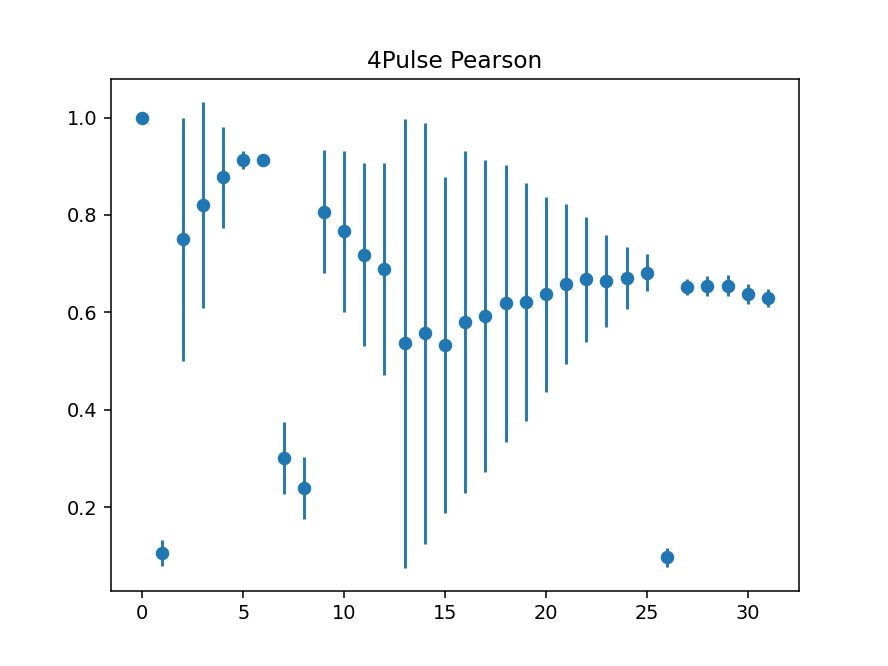

Text(0.5, 1.0, '4Pulse Pearson')

In [5]:
############### Pearson's Correlation Coefficient #################

### Create a mar=trix to store correlation coefficient for each sample of residuals
R_4p=np.ndarray([bootresult_4p.shape[0],bootresult_4p.shape[2],bootresult_4p.shape[2]])

## Calculate pearson Correlation coefficient for all samples
for i in range(bootresult_4p.shape[0]):
    R_4p[i,:,:]=np.corrcoef(bootresult_4p[i,:,:],rowvar=False)

##plotting the mean of correlation coefficient with oth channel as reference 
plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_4p[:,0,:],axis=0),yerr=1.96*(np.std(R_4p[:,0,:],axis=0)),fmt='o')
plt.title("4Pulse Pearson")


<IPython.core.display.Javascript object>


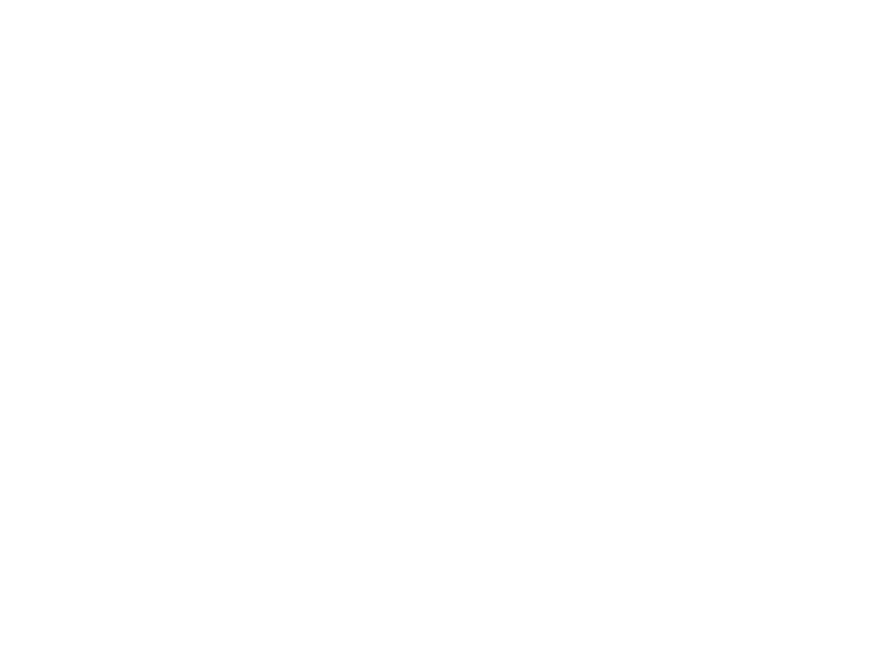

In [5]:
################### Spearman Correlation coefficient ##########

R_4p_spr=np.ndarray([bootresult_4p.shape[0],bootresult_4p.shape[2],bootresult_4p.shape[2]])
R_4p_spr_pval=np.ndarray([bootresult_4p.shape[0],bootresult_4p.shape[2],bootresult_4p.shape[2]])

for i in range(bootresult_4p.shape[0]):
    R_4p_spr[i,:,:]=scs.spearmanr(bootresult_4p[i,:,:],axis=0)[0]
    R_4p_spr_pval[i,:,:]=scs.spearmanr(bootresult_4p[i,:,:],axis=0)[1]

plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_4p_spr[:,0,:],axis=0),yerr=1.96*(np.std(R_4p_spr[:,0,:],axis=0)),fmt='o')
plt.title("4Pulse Spearman")
plt.show()

#os.chdir(cwd)

## 8 Pulse Integration

In [6]:
cwd = os.getcwd()
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/timFiles')

In [7]:
#residuals_8p = np.loadtxt('res_All_pulses_1000.txt')  # Read post fit residuals_8p from a file into a numpy array.
residuals_8p = np.genfromtxt('PostRes_8pulint_Entire_all.txt')
residuals_8p = residuals_8p.reshape((-1,32))  ## Getting residuals_8p in a matrix [subint,freq]

##Deleting the residuals corresponding to bad data
residuals_8p=np.delete(residuals_8p,[2152,2153,2156,2158],0)
residuals_8p.shape

#### Running bootstrap on residuals_8p to generate samples
with NumpyRNGContext(1):   
    bootresult_8p = ast.bootstrap(residuals_8p, 500)

<IPython.core.display.Javascript object>


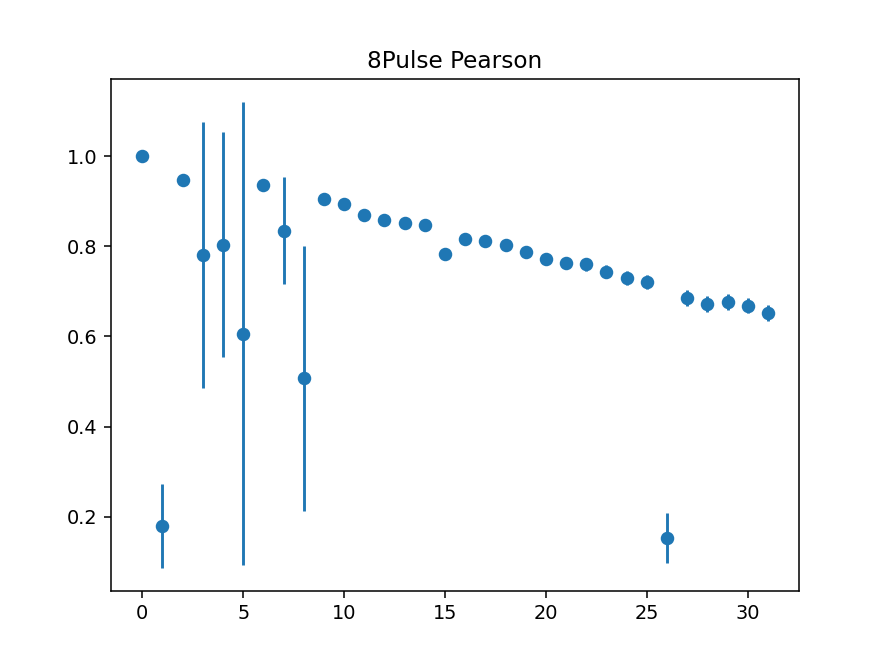

Text(0.5, 1.0, '8Pulse Pearson')

In [13]:
############### Pearson's Correlation Coefficient #################

### Create a mar=trix to store correlation coefficient for each sample of residuals
R_8p=np.ndarray([bootresult_8p.shape[0],bootresult_8p.shape[2],bootresult_8p.shape[2]])

## Calculate pearson Correlation coefficient for all samples
for i in range(bootresult_8p.shape[0]):
    R_8p[i,:,:]=np.corrcoef(bootresult_8p[i,:,:],rowvar=False)

##plotting the mean of correlation coefficient with oth channel as reference 
plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_8p[:,0,:],axis=0),yerr=1.96*(np.std(R_8p[:,0,:],axis=0)),fmt='o')
plt.title("8Pulse Pearson")


<IPython.core.display.Javascript object>


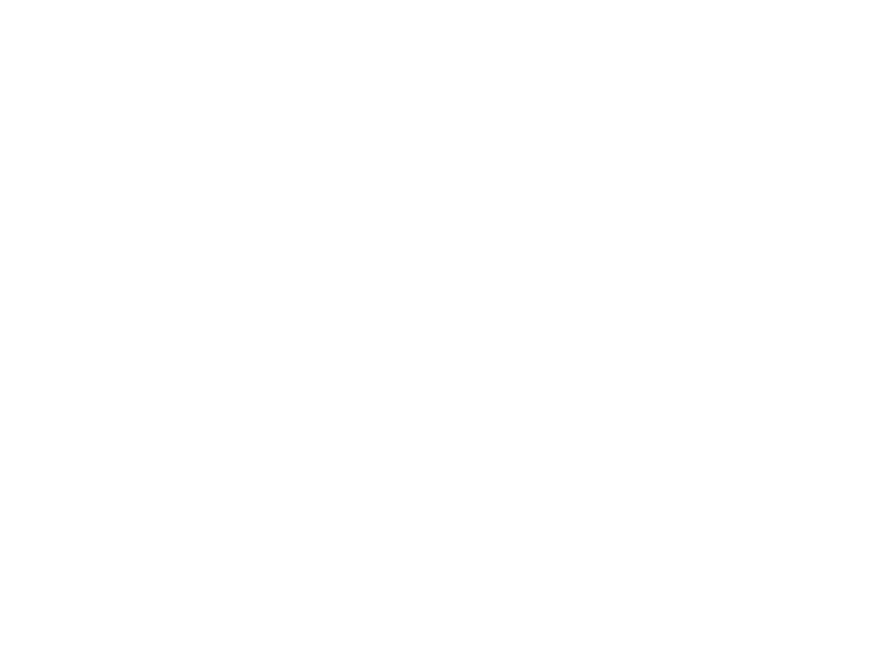

In [8]:
################### Spearman Correlation coefficient ##########

R_8p_spr=np.ndarray([bootresult_8p.shape[0],bootresult_8p.shape[2],bootresult_8p.shape[2]])
R_8p_spr_pval=np.ndarray([bootresult_8p.shape[0],bootresult_8p.shape[2],bootresult_8p.shape[2]])

for i in range(bootresult_8p.shape[0]):
    R_8p_spr[i,:,:]=scs.spearmanr(bootresult_8p[i,:,:],axis=0)[0]
    R_8p_spr_pval[i,:,:]=scs.spearmanr(bootresult_8p[i,:,:],axis=0)[1]

plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_8p_spr[:,0,:],axis=0),yerr=1.96*(np.std(R_8p_spr[:,0,:],axis=0)),fmt='o')
plt.title("8Pulse Spearman")
plt.show()

#os.chdir(cwd)

## 16 Pulse Integration

In [2]:
cwd = os.getcwd()
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/timFiles')

In [8]:
#residuals_16p = np.loadtxt('res_All_pulses_1000.txt')  # Read post fit residuals_16p from a file into a numpy array.
residuals_16p = np.genfromtxt('PostRes_16pulint_Entire_all.txt')
residuals_16p = residuals_16p.reshape((-1,32))  ## Getting residuals_16p in a matrix [subint,freq]

## Deleting residuals corresponding to bad data 
residuals_16p=np.delete(residuals_16p,[1076,1078],0)  ###_Original


#### Running bootstrap on residuals_16p to generate samples
with NumpyRNGContext(1):   
    bootresult_16p = ast.bootstrap(residuals_16p, 500)

In [9]:
residuals_16p.shape

(2746, 31)

<IPython.core.display.Javascript object>


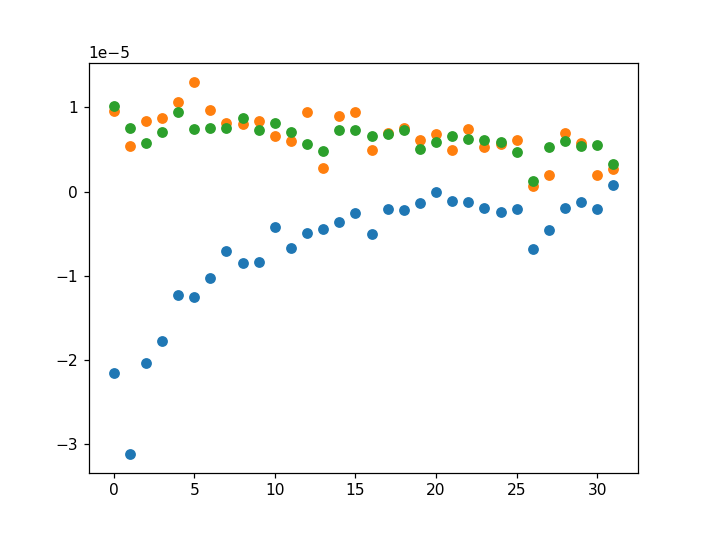

[9.61608025e-06 5.40466663e-06 8.40422449e-06 8.72683344e-06
 1.06879648e-05 1.30634843e-05 9.68332340e-06 8.15407689e-06
 7.97665721e-06 8.42634536e-06 6.56036988e-06 5.97285933e-06
 9.47766401e-06 2.84192516e-06 8.93987997e-06 9.51234982e-06
 4.97556479e-06 6.99870072e-06 7.53157354e-06 6.12572260e-06
 6.80040819e-06 4.99551671e-06 7.43764551e-06 5.33009692e-06
 5.68524309e-06 6.16347802e-06 6.67460598e-07 1.93336041e-06
 7.01406868e-06 5.73928731e-06 1.99597912e-06 2.67680384e-06]


In [5]:
plt.figure()
plt.scatter(np.linspace(0,31,num=32),residuals_16p[0,:])
plt.scatter(np.linspace(0,31,num=32),residuals_16p[2,:])
plt.scatter(np.linspace(0,31,num=32),residuals_16p[100,:])
print(residuals_16p[2,:])

<IPython.core.display.Javascript object>


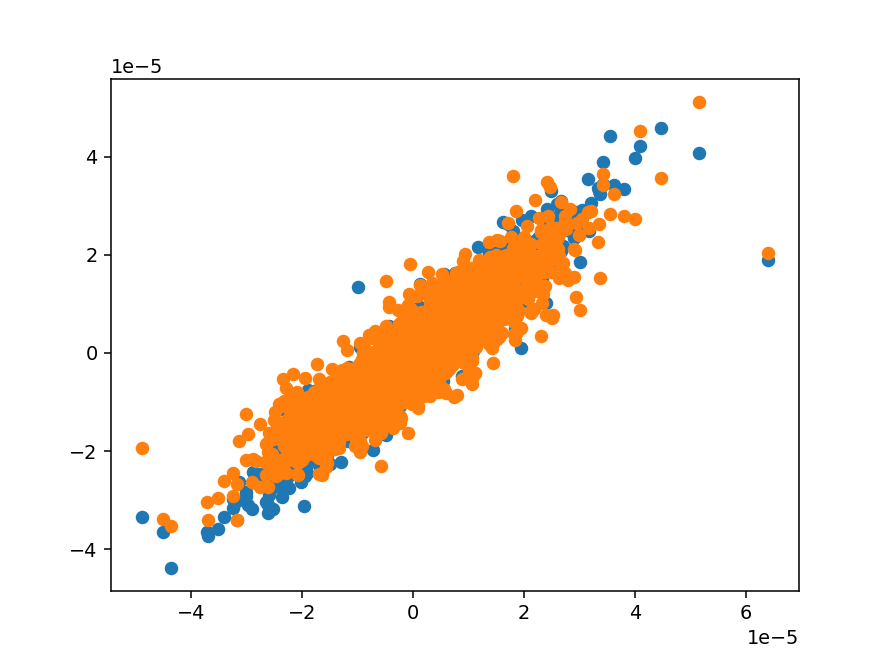

In [19]:
plt.figure()
#plt.plot(residuals_16p[:,0])#,residuals_16p[:,1])
plt.scatter(residuals_16p[:,0],residuals_16p[:,2])
plt.scatter(residuals_16p[:,0],residuals_16p[:,10])

<IPython.core.display.Javascript object>


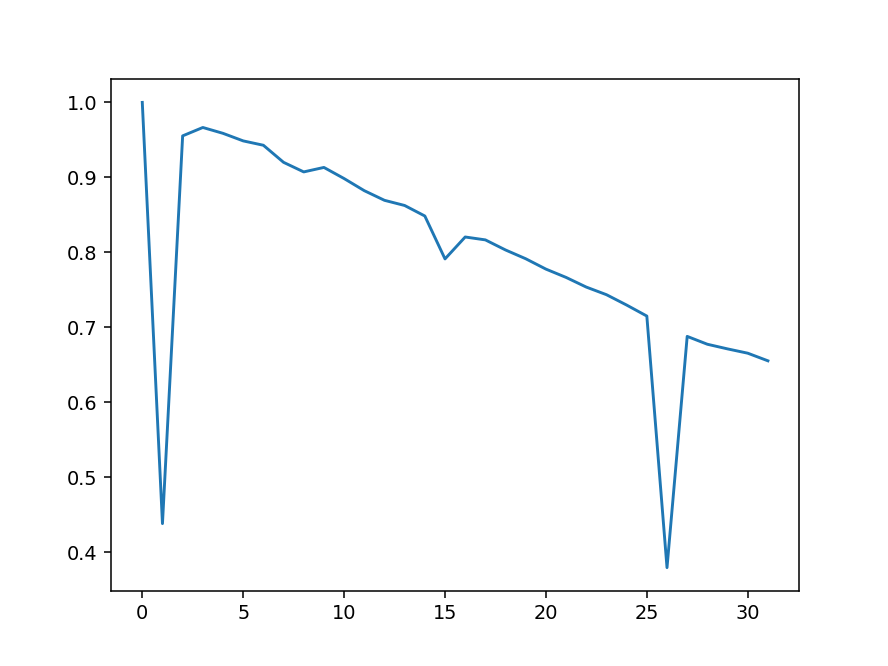

In [20]:
R_temp=np.ndarray([bootresult_16p.shape[2],bootresult_16p.shape[2]])
R_temp=np.corrcoef(residuals_16p[:,:],rowvar=False)
plt.figure()
plt.plot(R_temp[0,:])

<IPython.core.display.Javascript object>


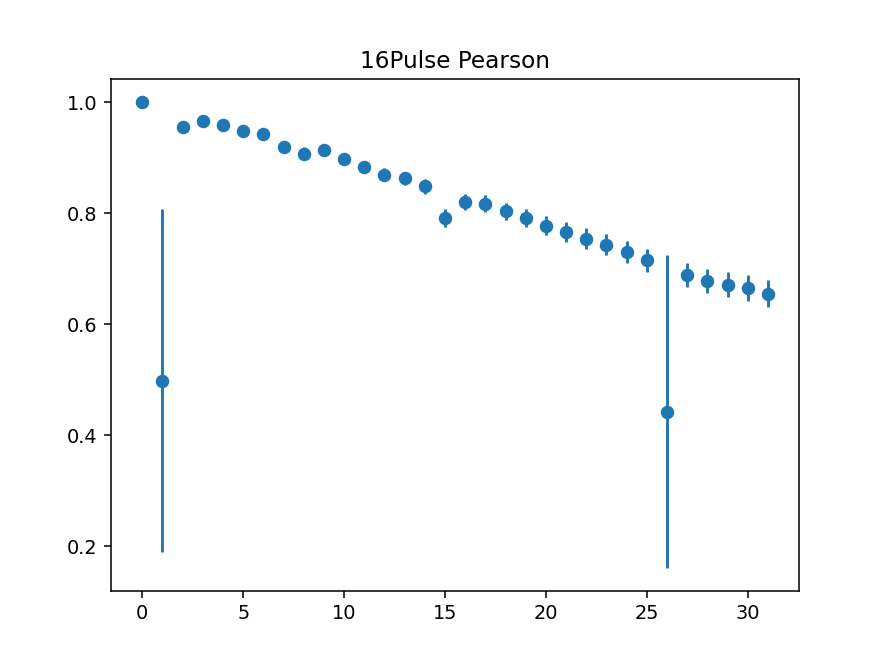

Text(0.5, 1.0, '16Pulse Pearson')

In [21]:
############### Pearson's Correlation Coefficient #################

### Create a mar=trix to store correlation coefficient for each sample of residuals
R_16p=np.ndarray([bootresult_16p.shape[0],bootresult_16p.shape[2],bootresult_16p.shape[2]])

## Calculate pearson Correlation coefficient for all samples
for i in range(bootresult_16p.shape[0]):
    R_16p[i,:,:]=np.corrcoef(bootresult_16p[i,:,:],rowvar=False)

##plotting the mean of correlation coefficient with oth channel as reference 
plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_16p[:,0,:],axis=0),yerr=1.96*(np.std(R_16p[:,0,:],axis=0)),fmt='o')
plt.title("16Pulse Pearson")


<IPython.core.display.Javascript object>


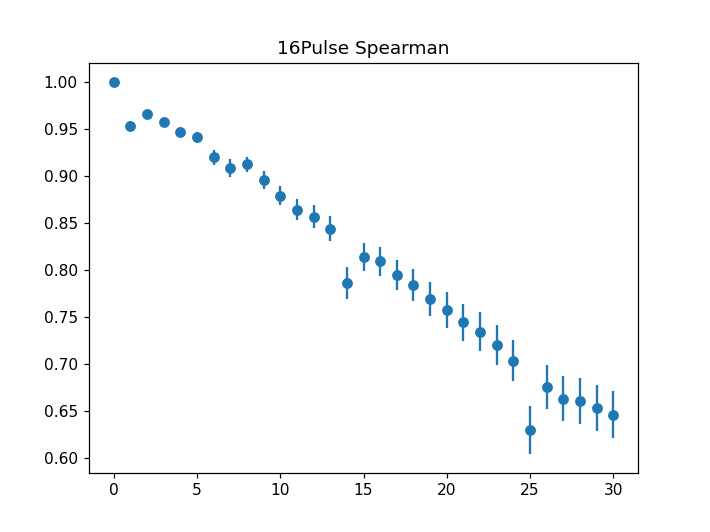

In [11]:
################### Spearman Correlation coefficient ##########

R_16p_spr=np.ndarray([bootresult_16p.shape[0],bootresult_16p.shape[2],bootresult_16p.shape[2]])
R_16p_spr_pval=np.ndarray([bootresult_16p.shape[0],bootresult_16p.shape[2],bootresult_16p.shape[2]])

for i in range(bootresult_16p.shape[0]):
    R_16p_spr[i,:,:]=scs.spearmanr(bootresult_16p[i,:,:],axis=0)[0]
    R_16p_spr_pval[i,:,:]=scs.spearmanr(bootresult_16p[i,:,:],axis=0)[1]

plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_16p_spr[:,0,:],axis=0),yerr=1.96*(np.std(R_16p_spr[:,0,:],axis=0)),fmt='o')
plt.title("16Pulse Spearman")
plt.show()

#os.chdir(cwd)

## 32 Pulse Integration

<IPython.core.display.Javascript object>


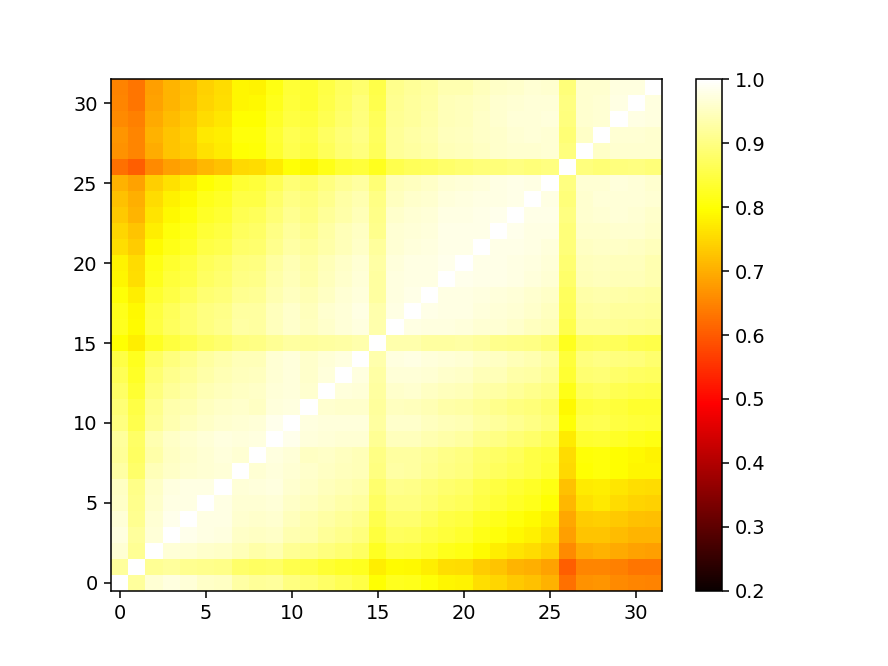

In [54]:
plt.figure()
plt.imshow(R_32p_spr[0],vmin=0.2,vmax=1,cmap='hot',aspect='auto',origin='lower')
plt.colorbar()

<IPython.core.display.Javascript object>


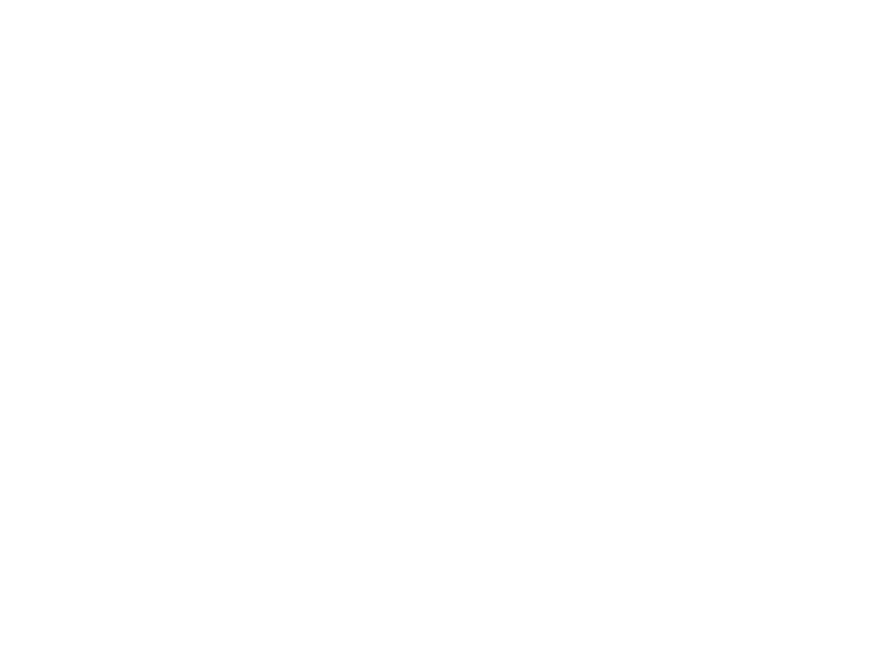

In [88]:
plt.figure()
plt.plot(np.correlate(residuals_32p[:,0]-np.mean(residuals_32p[:,0]),residuals_32p[:,0]-np.mean(residuals_32p[:,0]),"full"))

## 64 Pulse Integration

In [15]:
cwd = os.getcwd()
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/timFiles')

In [16]:
#residuals_64p = np.loadtxt('res_All_pulses_1000.txt')  # Read post fit residuals_64p from a file into a numpy array.
residuals_64p = np.genfromtxt('PostRes_64pulint_Entire_all.txt')
residuals_64p = residuals_64p.reshape((-1,32))  ## Getting residuals_64p in a matrix [subint,freq]

##Deleting residuals corresponding to bad data
residuals_64p=np.delete(residuals_64p,[287],0)
residuals_64p.shape

#### Running bootstrap on residuals_64p to generate samples
with NumpyRNGContext(1):   
    bootresult_64p = ast.bootstrap(residuals_64p, 500)

In [ ]:
############### Pearson's Correlation Coefficient #################

### Create a mar=trix to store correlation coefficient for each sample of residuals
R_64p=np.ndarray([bootresult_64p.shape[0],bootresult_64p.shape[2],bootresult_64p.shape[2]])

## Calculate pearson Correlation coefficient for all samples
for i in range(bootresult_64p.shape[0]):
    R_64p[i,:,:]=np.corrcoef(bootresult_64p[i,:,:],rowvar=False)

##plotting the mean of correlation coefficient with oth channel as reference 
plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_64p[:,0,:],axis=0),yerr=1.96*(np.std(R_64p[:,0,:],axis=0)),fmt='o')
plt.title("64Pulse Pearson")


<IPython.core.display.Javascript object>


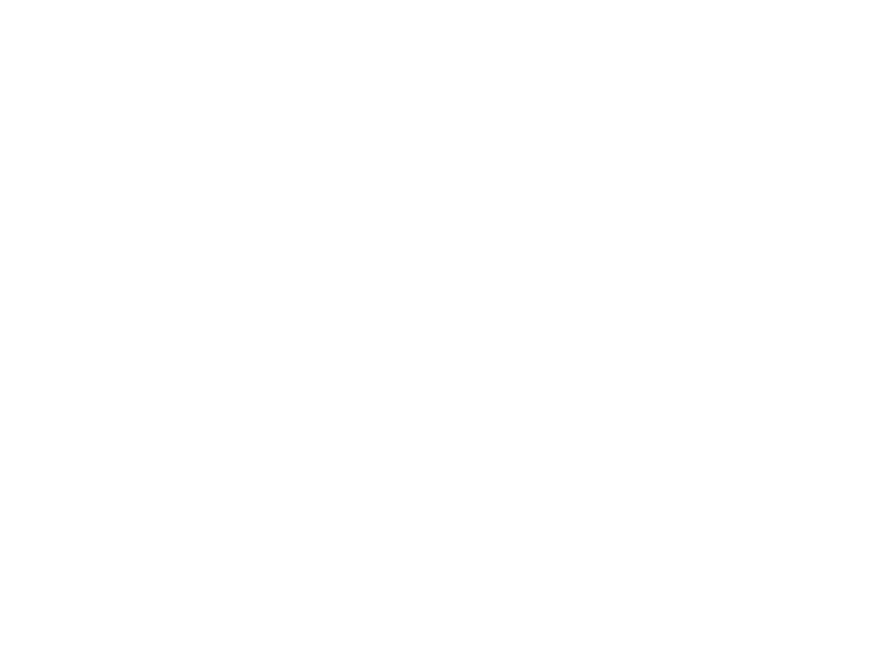

In [17]:
################### Spearman Correlation coefficient ##########

R_64p_spr=np.ndarray([bootresult_64p.shape[0],bootresult_64p.shape[2],bootresult_64p.shape[2]])
R_64p_spr_pval=np.ndarray([bootresult_64p.shape[0],bootresult_64p.shape[2],bootresult_64p.shape[2]])

for i in range(bootresult_64p.shape[0]):
    R_64p_spr[i,:,:]=scs.spearmanr(bootresult_64p[i,:,:],axis=0)[0]
    R_64p_spr_pval[i,:,:]=scs.spearmanr(bootresult_64p[i,:,:],axis=0)[1]

plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_64p_spr[:,0,:],axis=0),yerr=1.96*(np.std(R_64p_spr[:,0,:],axis=0)),fmt='o')
plt.title("64Pulse Spearman")
plt.show()

#os.chdir(cwd)

## 128 Pulse Integration

In [18]:
cwd = os.getcwd()
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/timFiles')

In [19]:
#residuals_128p = np.loadtxt('res_All_pulses_1000.txt')  # Read post fit residuals_128p from a file into a numpy array.
residuals_128p = np.genfromtxt('PostRes_128pulint_Entire_all.txt')
residuals_128p = residuals_128p.reshape((-1,32))  ## Getting residuals_128p in a matrix [subint,freq]

##Deleting residuals corresponding to bad data
#residuals_128p=np.delete(residuals_128p,[538,539],0)
residuals_128p.shape

#### Running bootstrap on residuals_128p to generate samples
with NumpyRNGContext(1):   
    bootresult_128p = ast.bootstrap(residuals_128p, 500)

<IPython.core.display.Javascript object>


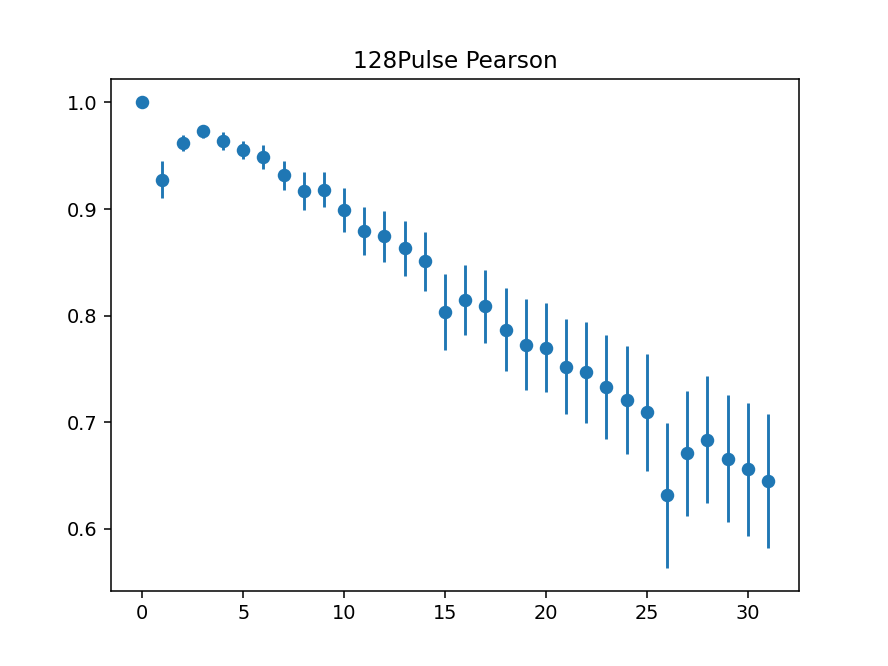

Text(0.5, 1.0, '128Pulse Pearson')

In [33]:
############### Pearson's Correlation Coefficient #################

### Create a mar=trix to store correlation coefficient for each sample of residuals
R_128p=np.ndarray([bootresult_128p.shape[0],bootresult_128p.shape[2],bootresult_128p.shape[2]])

## Calculate pearson Correlation coefficient for all samples
for i in range(bootresult_128p.shape[0]):
    R_128p[i,:,:]=np.corrcoef(bootresult_128p[i,:,:],rowvar=False)

##plotting the mean of correlation coefficient with oth channel as reference 
plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_128p[:,0,:],axis=0),yerr=1.96*(np.std(R_128p[:,0,:],axis=0)),fmt='o')
plt.title("128Pulse Pearson")


<IPython.core.display.Javascript object>


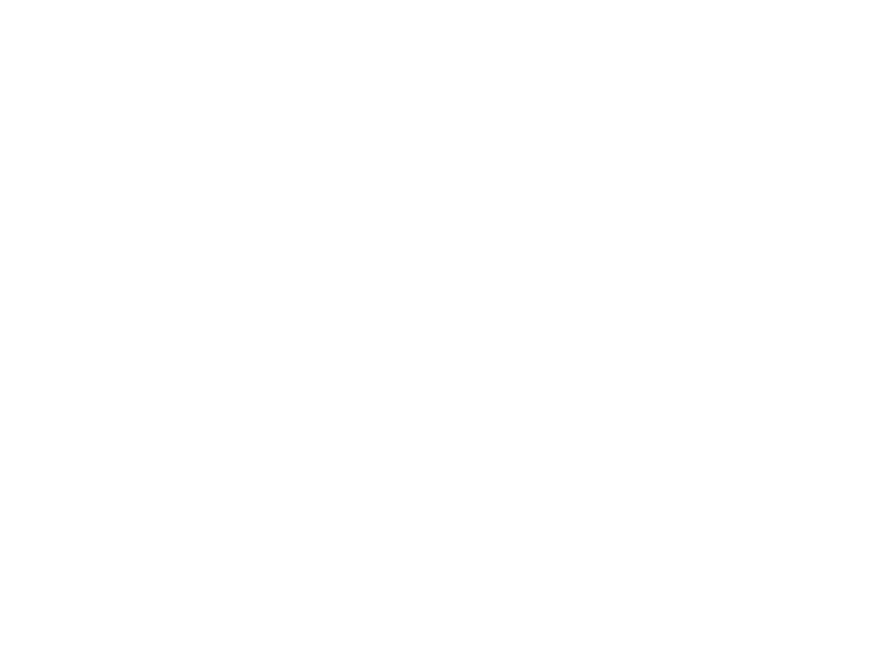

In [20]:
################### Spearman Correlation coefficient ##########

R_128p_spr=np.ndarray([bootresult_128p.shape[0],bootresult_128p.shape[2],bootresult_128p.shape[2]])
R_128p_spr_pval=np.ndarray([bootresult_128p.shape[0],bootresult_128p.shape[2],bootresult_128p.shape[2]])

for i in range(bootresult_128p.shape[0]):
    R_128p_spr[i,:,:]=scs.spearmanr(bootresult_128p[i,:,:],axis=0)[0]
    R_128p_spr_pval[i,:,:]=scs.spearmanr(bootresult_128p[i,:,:],axis=0)[1]

plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_128p_spr[:,0,:],axis=0),yerr=1.96*(np.std(R_128p_spr[:,0,:],axis=0)),fmt='o')
plt.title("128Pulse Spearman")
plt.show()

#os.chdir(cwd)

## 256 Pulse Integration

In [21]:
cwd = os.getcwd()
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/timFiles')

In [22]:
#residuals_256p = np.loadtxt('res_All_pulses_1000.txt')  # Read post fit residuals_256p from a file into a numpy array.
residuals_256p = np.genfromtxt('PostRes_256pulint_Entire_all.txt')
residuals_256p = residuals_256p.reshape((-1,32))  ## Getting residuals_256p in a matrix [subint,freq]

##Deleting residuals corresponding to bad data
#residuals_256p=np.delete(residuals_256p,[538,539],0)
residuals_256p.shape

#### Running bootstrap on residuals_256p to generate samples
with NumpyRNGContext(1):   
    bootresult_256p = ast.bootstrap(residuals_256p, 500)

<IPython.core.display.Javascript object>


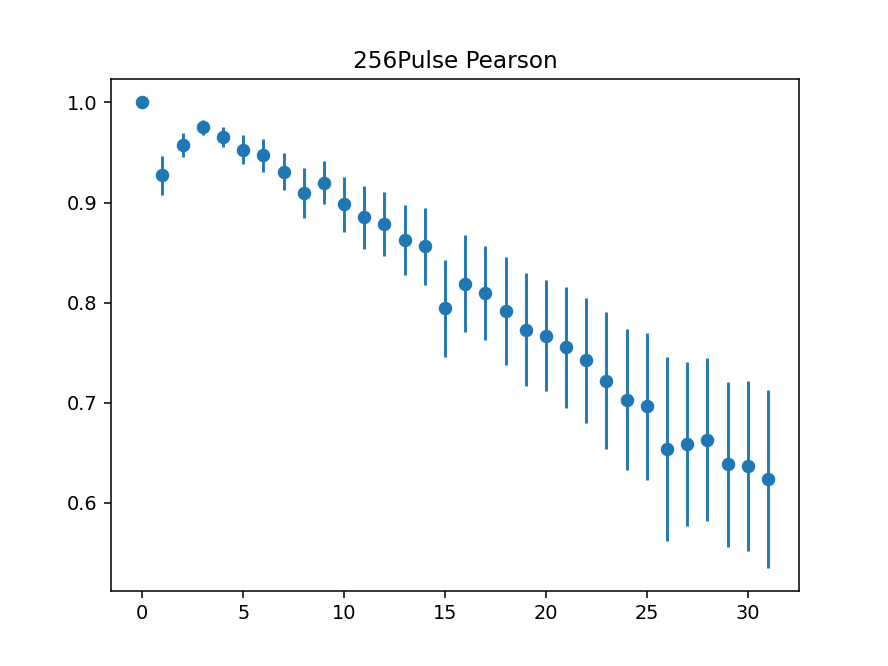

Text(0.5, 1.0, '256Pulse Pearson')

In [37]:
############### Pearson's Correlation Coefficient #################

### Create a mar=trix to store correlation coefficient for each sample of residuals
R_256p=np.ndarray([bootresult_256p.shape[0],bootresult_256p.shape[2],bootresult_256p.shape[2]])

## Calculate pearson Correlation coefficient for all samples
for i in range(bootresult_256p.shape[0]):
    R_256p[i,:,:]=np.corrcoef(bootresult_256p[i,:,:],rowvar=False)

##plotting the mean of correlation coefficient with oth channel as reference 
plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_256p[:,0,:],axis=0),yerr=1.96*(np.std(R_256p[:,0,:],axis=0)),fmt='o')
plt.title("256Pulse Pearson")


<IPython.core.display.Javascript object>


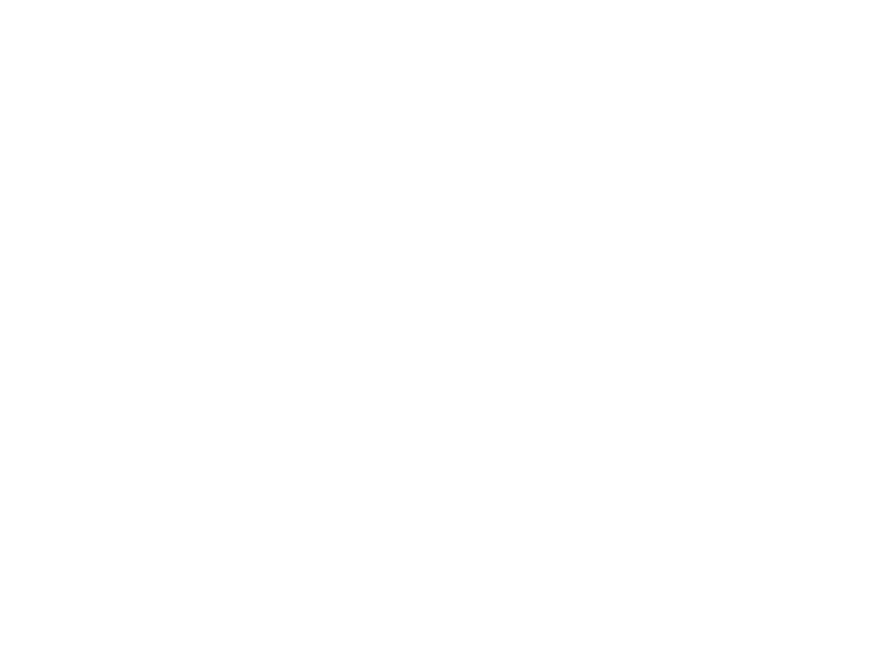

In [23]:
################### Spearman Correlation coefficient ##########

R_256p_spr=np.ndarray([bootresult_256p.shape[0],bootresult_256p.shape[2],bootresult_256p.shape[2]])
R_256p_spr_pval=np.ndarray([bootresult_256p.shape[0],bootresult_256p.shape[2],bootresult_256p.shape[2]])

for i in range(bootresult_256p.shape[0]):
    R_256p_spr[i,:,:]=scs.spearmanr(bootresult_256p[i,:,:],axis=0)[0]
    R_256p_spr_pval[i,:,:]=scs.spearmanr(bootresult_256p[i,:,:],axis=0)[1]

plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_256p_spr[:,0,:],axis=0),yerr=1.96*(np.std(R_256p_spr[:,0,:],axis=0)),fmt='o')
plt.title("256Pulse Spearman")
plt.show()

#os.chdir(cwd)

## 512 Pulse Integration

In [24]:
cwd = os.getcwd()
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/timFiles')

In [25]:
#residuals_512p = np.loadtxt('res_All_pulses_1000.txt')  # Read post fit residuals_512p from a file into a numpy array.
residuals_512p = np.genfromtxt('PostRes_512pulint_Entire_all.txt')
residuals_512p = residuals_512p.reshape((-1,32))  ## Getting residuals_512p in a matrix [subint,freq]

##Deleting residuals corresponding to bad data
#residuals_512p=np.delete(residuals_512p,[538,539],0)
residuals_512p.shape

#### Running bootstrap on residuals_512p to generate samples
with NumpyRNGContext(1):   
    bootresult_512p = ast.bootstrap(residuals_512p, 500)

<IPython.core.display.Javascript object>


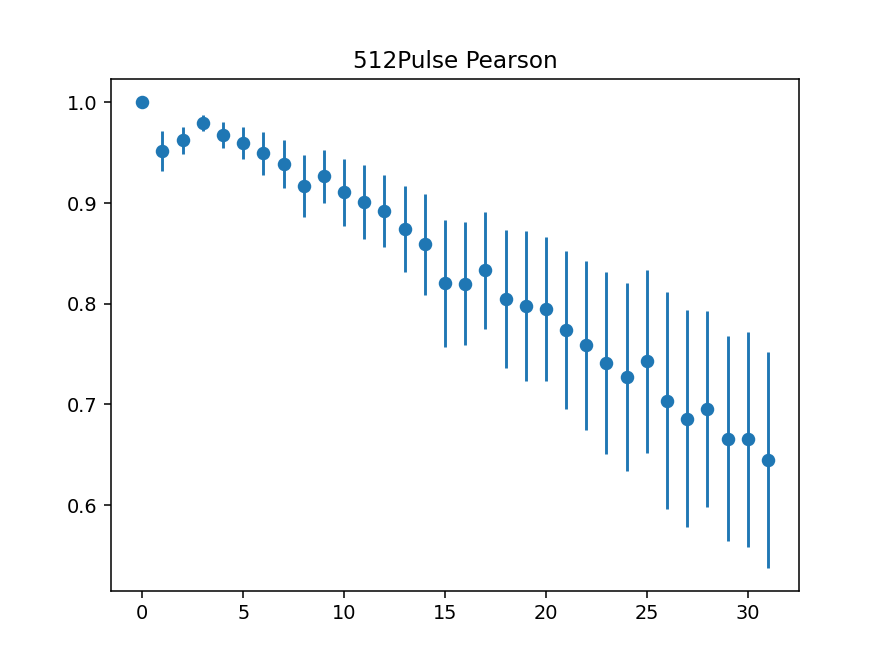

Text(0.5, 1.0, '512Pulse Pearson')

In [41]:
############### Pearson's Correlation Coefficient #################

### Create a mar=trix to store correlation coefficient for each sample of residuals
R_512p=np.ndarray([bootresult_512p.shape[0],bootresult_512p.shape[2],bootresult_512p.shape[2]])

## Calculate pearson Correlation coefficient for all samples
for i in range(bootresult_512p.shape[0]):
    R_512p[i,:,:]=np.corrcoef(bootresult_512p[i,:,:],rowvar=False)

##plotting the mean of correlation coefficient with oth channel as reference 
plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_512p[:,0,:],axis=0),yerr=1.96*(np.std(R_512p[:,0,:],axis=0)),fmt='o')
plt.title("512Pulse Pearson")


<IPython.core.display.Javascript object>


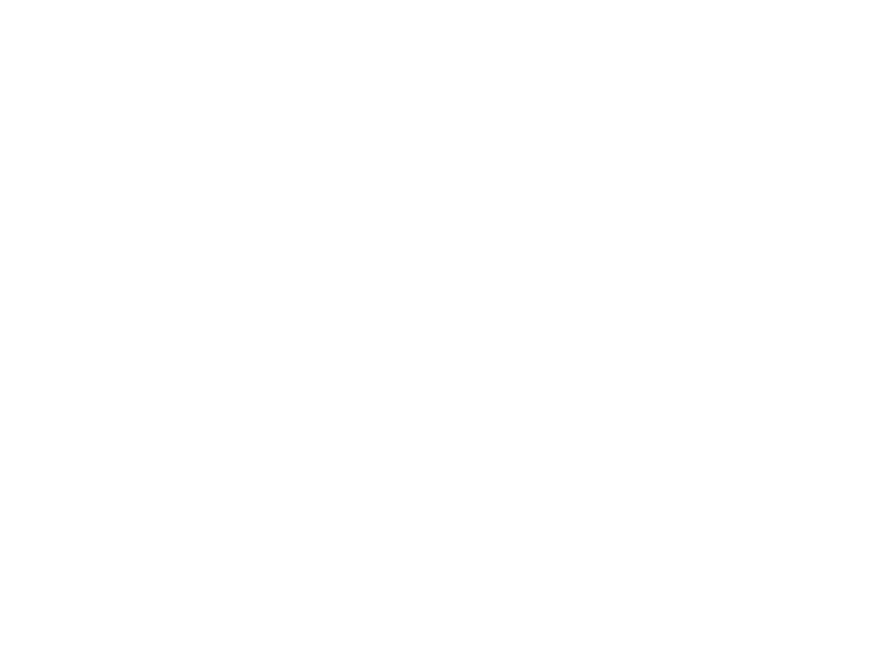

In [26]:
################### Spearman Correlation coefficient ##########

R_512p_spr=np.ndarray([bootresult_512p.shape[0],bootresult_512p.shape[2],bootresult_512p.shape[2]])
R_512p_spr_pval=np.ndarray([bootresult_512p.shape[0],bootresult_512p.shape[2],bootresult_512p.shape[2]])

for i in range(bootresult_512p.shape[0]):
    R_512p_spr[i,:,:]=scs.spearmanr(bootresult_512p[i,:,:],axis=0)[0]
    R_512p_spr_pval[i,:,:]=scs.spearmanr(bootresult_512p[i,:,:],axis=0)[1]

plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_512p_spr[:,0,:],axis=0),yerr=1.96*(np.std(R_512p_spr[:,0,:],axis=0)),fmt='o')
plt.title("512Pulse Spearman")
plt.show()

#os.chdir(cwd)

## 1024 Pulse Integration

In [90]:
cwd = os.getcwd()
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/timFiles')

In [91]:
#residuals_1024p = np.loadtxt('res_All_pulses_1000.txt')  # Read post fit residuals_1024p from a file into a numpy array.
residuals_1024p = np.genfromtxt('PostRes_1024pulint_Entire_all.txt')
residuals_1024p = residuals_1024p.reshape((-1,32))  ## Getting residuals_1024p in a matrix [subint,freq]

##Deleting residuals corresponding to bad data
#residuals_1024p=np.delete(residuals_1024p,[538,539],0)
residuals_1024p.shape

#### Running bootstrap on residuals_1024p to generate samples
with NumpyRNGContext(1):   
    bootresult_1024p = ast.bootstrap(residuals_1024p, 500)

/tmp/ipykernel_34204/5740128.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


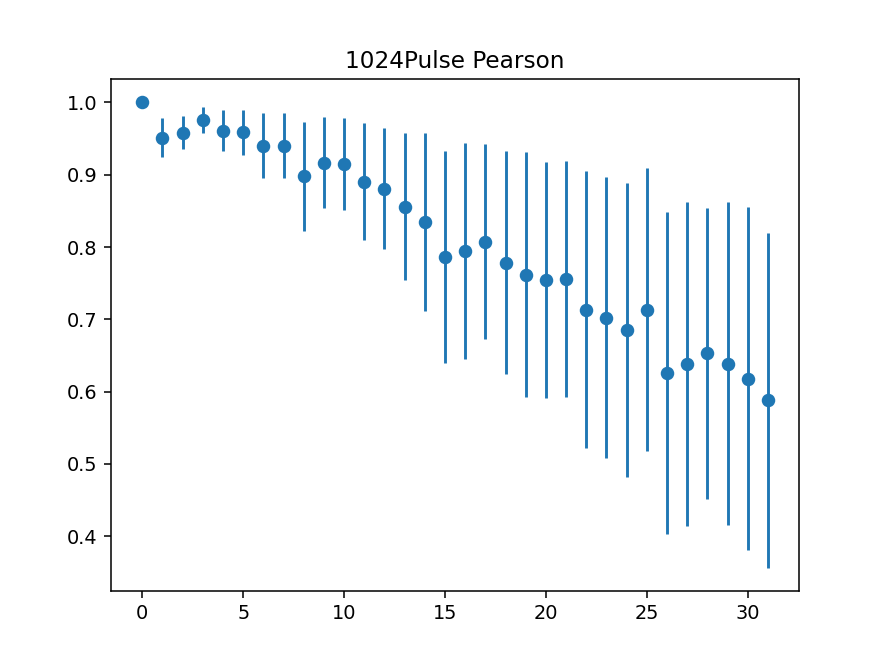

Text(0.5, 1.0, '1024Pulse Pearson')

In [45]:
############### Pearson's Correlation Coefficient #################

### Create a mar=trix to store correlation coefficient for each sample of residuals
R_1024p=np.ndarray([bootresult_1024p.shape[0],bootresult_1024p.shape[2],bootresult_1024p.shape[2]])

## Calculate pearson Correlation coefficient for all samples
for i in range(bootresult_1024p.shape[0]):
    R_1024p[i,:,:]=np.corrcoef(bootresult_1024p[i,:,:],rowvar=False)

##plotting the mean of correlation coefficient with oth channel as reference 
plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_1024p[:,0,:],axis=0),yerr=1.96*(np.std(R_1024p[:,0,:],axis=0)),fmt='o')
plt.title("1024Pulse Pearson")


<IPython.core.display.Javascript object>


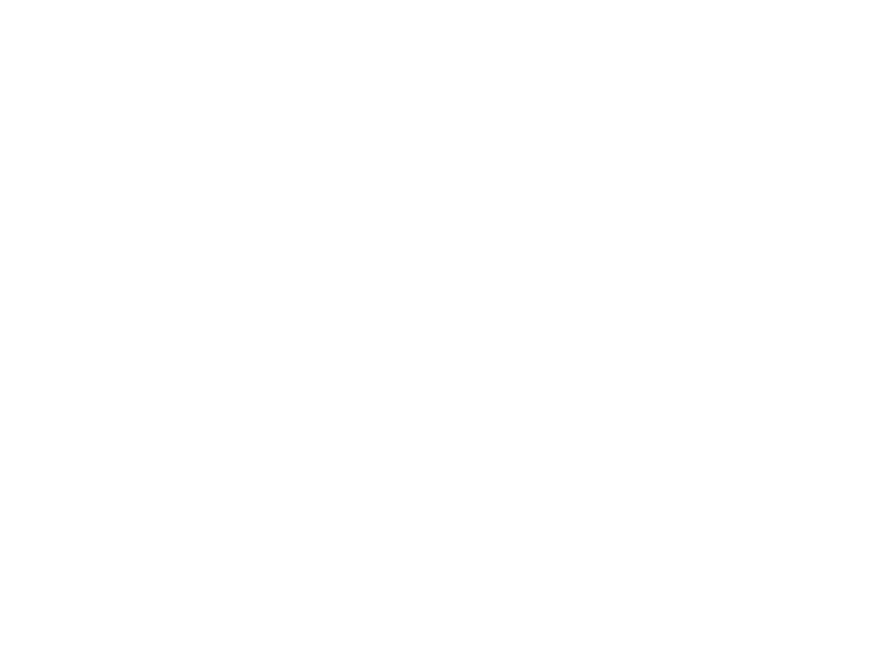

In [92]:
################### Spearman Correlation coefficient ##########

R_1024p_spr=np.ndarray([bootresult_1024p.shape[0],bootresult_1024p.shape[2],bootresult_1024p.shape[2]])
R_1024p_spr_pval=np.ndarray([bootresult_1024p.shape[0],bootresult_1024p.shape[2],bootresult_1024p.shape[2]])

for i in range(bootresult_1024p.shape[0]):
    R_1024p_spr[i,:,:]=scs.spearmanr(bootresult_1024p[i,:,:],axis=0)[0]
    R_1024p_spr_pval[i,:,:]=scs.spearmanr(bootresult_1024p[i,:,:],axis=0)[1]

plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_1024p_spr[:,0,:],axis=0),yerr=1.96*(np.std(R_1024p_spr[:,0,:],axis=0)),fmt='o')
plt.title("1024Pulse Spearman")
plt.show()

#os.chdir(cwd)

## 8sec Pulse Integration

In [30]:
cwd = os.getcwd()
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/timFiles')

In [31]:
#residuals_8secp = np.loadtxt('res_All_pulses_1000.txt')  # Read post fit residuals_8secp from a file into a numpy array.
residuals_8secp = np.genfromtxt('PostRes_8secInt_Entire_all.txt')
residuals_8secp = residuals_8secp.reshape((-1,32))  ## Getting residuals_8secp in a matrix [subint,freq]

##Deleting residuals corresponding to bad data
#residuals_8secp=np.delete(residuals_8secp,[538,539],0)
residuals_8secp.shape

#### Running bootstrap on residuals_8secp to generate samples
with NumpyRNGContext(1):   
    bootresult_8secp = ast.bootstrap(residuals_8secp, 500)

In [ ]:
plt.figure()
plt.scatter(np.linspace(0,1056,num=1056),residuals_8secp)

In [ ]:
############### Pearson's Correlation Coefficient #################

### Create a mar=trix to store correlation coefficient for each sample of residuals
R_8secp=np.ndarray([bootresult_8secp.shape[0],bootresult_8secp.shape[2],bootresult_8secp.shape[2]])

## Calculate pearson Correlation coefficient for all samples
for i in range(bootresult_8secp.shape[0]):
    R_8secp[i,:,:]=np.corrcoef(bootresult_8secp[i,:,:],rowvar=False)

##plotting the mean of correlation coefficient with oth channel as reference 
plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_8secp[:,0,:],axis=0),yerr=1.96*(np.std(R_8secp[:,0,:],axis=0)),fmt='o')
plt.title("8secPulse Pearson")


<IPython.core.display.Javascript object>


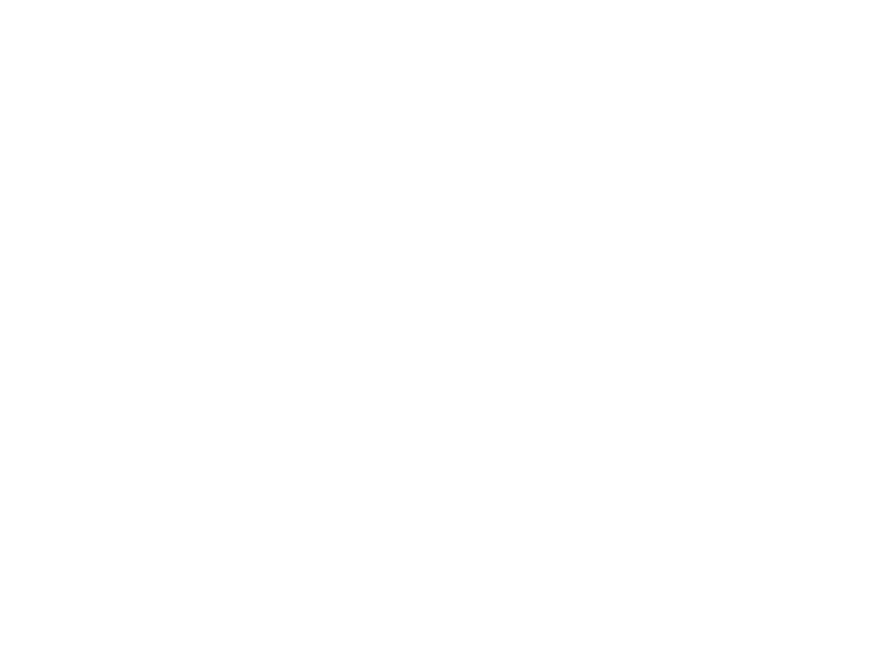

In [32]:
################### Spearman Correlation coefficient ##########

R_8secp_spr=np.ndarray([bootresult_8secp.shape[0],bootresult_8secp.shape[2],bootresult_8secp.shape[2]])
R_8secp_spr_pval=np.ndarray([bootresult_8secp.shape[0],bootresult_8secp.shape[2],bootresult_8secp.shape[2]])

for i in range(bootresult_8secp.shape[0]):
    R_8secp_spr[i,:,:]=scs.spearmanr(bootresult_8secp[i,:,:],axis=0)[0]
    R_8secp_spr_pval[i,:,:]=scs.spearmanr(bootresult_8secp[i,:,:],axis=0)[1]

plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_8secp_spr[:,0,:],axis=0),yerr=1.96*(np.std(R_8secp_spr[:,0,:],axis=0)),fmt='o')
plt.title("8secPulse Spearman")
plt.show()

#os.chdir(cwd)

In [ ]:
plt.figure()
#plt.plot(residuals_16p[:,0])#,residuals_16p[:,1])
plt.scatter(residuals_8secp[:,0],residuals_8secp[:,2])
plt.scatter(residuals_8secp[:,0],residuals_8secp[:,30])

## Entire Observation

In [ ]:
cwd = os.getcwd()
os.chdir('/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/timFiles')


In [ ]:
#residuals_Entire = np.loadtxt('res_All_pulses_1000.txt')  # Read post fit residuals_Entire from a file into a numpy array.
residuals_Entire = np.genfromtxt('PostRes_8secIntegrated_all.txt')
residuals_Entire = residuals_Entire.reshape((-1,32))  ## Getting residuals_Entire in a matrix [subint,freq]

#### Running bootstrap on residuals_Entire to generate samples
with NumpyRNGContext(1):   
    bootresult_Entire = ast.bootstrap(residuals_Entire, 500)

In [ ]:
plt.figure()
plt.scatter(np.linspace(0,1056,num=1056),residuals_Entire)

In [ ]:
############### Pearson's Correlation Coefficient #################

### Create a mar=trix to store correlation coefficient for each sample of residuals
R_Entire=np.ndarray([bootresult_Entire.shape[0],bootresult_Entire.shape[2],bootresult_Entire.shape[2]])

## Calculate pearson Correlation coefficient for all samples
for i in range(bootresult_Entire.shape[0]):
    R_Entire[i,:,:]=np.corrcoef(bootresult_Entire[i,:,:],rowvar=False)

##plotting the mean of correlation coefficient with oth channel as reference 
plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_Entire[:,0,:],axis=0),yerr=1.96*(np.std(R_Entire[:,0,:],axis=0)),fmt='o')
plt.title("Entire Observation Pearson")


In [ ]:
################### Spearman Correlation coefficient ##########

R_Entire_spr=np.ndarray([bootresult_Entire.shape[0],bootresult_Entire.shape[2],bootresult_Entire.shape[2]])
R_Entire_spr_pval=np.ndarray([bootresult_Entire.shape[0],bootresult_Entire.shape[2],bootresult_Entire.shape[2]])

for i in range(bootresult_Entire.shape[0]):
    R_Entire_spr[i,:,:]=scs.spearmanr(bootresult_Entire[i,:,:],axis=0)[0]
    R_Entire_spr_pval[i,:,:]=scs.spearmanr(bootresult_Entire[i,:,:],axis=0)[1]

plt.figure()
plt.errorbar(np.linspace(0,31,num=32),np.mean(R_Entire_spr[:,0,:],axis=0),yerr=1.96*(np.std(R_Entire_spr[:,0,:],axis=0)),fmt='o')
plt.title("Entire Spearman")
plt.show()

#os.chdir(cwd)

In [ ]:
plt.figure()
#plt.plot(residuals_16p[:,0])#,residuals_16p[:,1])
plt.scatter(residuals_Entire[:,0],residuals_Entire[:,2])
plt.scatter(residuals_Entire[:,0],residuals_Entire[:,30])

<IPython.core.display.Javascript object>


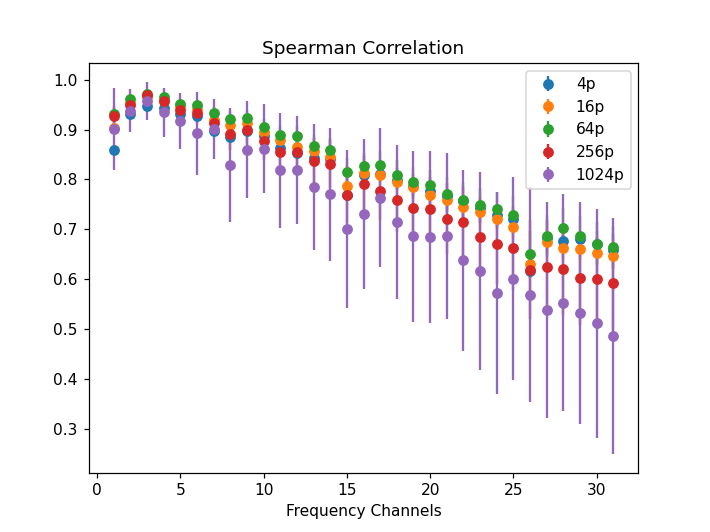

In [104]:
plt.figure()
plt.errorbar(np.linspace(1,31,num=31),np.mean(R_4p_spr[:,0,1:32],axis=0),yerr=1.96*(np.std(R_4p_spr[:,0,1:32],axis=0)),fmt='o',label='4p')
#plt.errorbar(np.linspace(1,31,num=31),np.mean(R_8p_spr[:,0,1:32],axis=0),yerr=1.96*(np.std(R_8p_spr[:,0,1:32],axis=0)),fmt='o',label='8p')
plt.errorbar(np.linspace(1,31,num=31),np.mean(R_16p_spr[:,0,1:32],axis=0),yerr=1.96*(np.std(R_16p_spr[:,0,1:32],axis=0)),fmt='o',label='16p')
#plt.errorbar(np.linspace(1,31,num=31),np.mean(R_32p_spr[:,0,1:32],axis=0),yerr=1.96*(np.std(R_32p_spr[:,0,1:32],axis=0)),fmt='o',label='32p')
plt.errorbar(np.linspace(1,31,num=31),np.mean(R_64p_spr[:,0,1:32],axis=0),yerr=1.96*(np.std(R_64p_spr[:,0,1:32],axis=0)),fmt='o',label='64p')
#plt.errorbar(np.linspace(1,31,num=31),np.mean(R_128p_spr[:,0,1:32],axis=0),yerr=1.96*(np.std(R_128p_spr[:,0,1:32],axis=0)),fmt='o',label='128p')
plt.errorbar(np.linspace(1,31,num=31),np.mean(R_256p_spr[:,0,1:32],axis=0),yerr=1.96*(np.std(R_256p_spr[:,0,1:32],axis=0)),fmt='o',label='256p')
#plt.errorbar(np.linspace(1,31,num=31),np.mean(R_512p_spr[:,0,1:32],axis=0),yerr=1.96*(np.std(R_512p_spr[:,0,1:32],axis=0)),fmt='o',label='512p')
plt.errorbar(np.linspace(1,31,num=31),np.mean(R_1024p_spr[:,0,1:32],axis=0),yerr=1.96*(np.std(R_1024p_spr[:,0,1:32],axis=0)),fmt='o',label='1024p')
#plt.errorbar(np.linspace(1,31,num=31),np.mean(R_8secp_spr[:,0,1:32],axis=0),yerr=1.96*(np.std(R_8secp_spr[:,0,1:32],axis=0)),fmt='o',label='8secPulse Spearman')
#plt.title("8secPulse Spearman")
plt.title('Spearman Correlation')
plt.xlabel('Frequency Channels')
plt.legend()

In [103]:
np.mean(R_4p_spr[:,0,0:32],axis=0).shape


(32,)